In [1]:
import sys, os, warnings
from importlib import reload
import json, csv

import math , pywt , numpy as np, pandas as pd
import scipy.stats as stats, scipy.signal as signal

from IPython.display import display, HTML
import matplotlib
import matplotlib.pyplot as plt


import utils
reload(utils)
from utils import *

import constants
reload(constants)
from constants import *

--> Importing bpmn_utils module file.

--> Importing grouped_mean module file.

--> Importing lhipa_utils module file.



In [2]:
# Config 

EYE_IMOTIONSFEATURES_AND_AOIS_FILE = DATA_DIR + r'\eventsDataWithAois.csv' 
PERCEIVED_DIFFICULTY_DATA = DATA_DIR + r'\perceivedDifficulty.csv'
EYEMIND_FULL_DATA = DATA_DIR + r'\allDataEyeMind.csv'
PUPIL_FILTERED_FILE = DATA_DIR + r'\PupilData_filtered.csv'
ANSWERS_DATA = DATA_DIR + r'\answers.csv'

QUESTION_FILE_PARSED = ORIG_DIR + r'\QuestionSetParsed.csv'
QUESTION_DETAILS = ORIG_DIR + r'\QuestionDetails.csv'

DEMOGRAPHIC_DATA = DATA_DIR + r'\surveys.csv'
DEMOGRAPHIC_CATALOG_DATA = DATA_DIR + r'\surveys_catalog.json'
DEMOGRAPHIC_RCATALOG_DATA = DATA_DIR + r'\surveys_rcatalog.json'

IMG_DIR = DATA_DIR + 'img'
if not os.path.exists(IMG_DIR): os.mkdir(IMG_DIR)

BASE_DIR = r'C:\DEV\ProcessModelMetricsR\ProcessMetricsCalculator'
MODELS_DIR = BASE_DIR + r'\models\base_models'
AOIS_DIR = BASE_DIR + r'\metric-analysis\AOIs'

###
# Due to typos in the experiment settings essential/accitenlComplexittty
COMPL = {'ESS', 'essentialComlexity', 'ACC', 'accidentalComlexity'}


In [3]:
def get_subparts(d, qElements):
    # Apply LHIPA BEFORE and AFTER the latest timestamp of the question elements
    # 1. Find first fix on the question elements
    #qElements = (tDetails['element1'].iloc[0], tDetails['element2'].iloc[0])
    d['qElement'] = 0
    d.loc[d['element']==qElements[0], ['qElement']] = 1
    d.loc[d['element']==qElements[1], ['qElement']] = 2
    d_qElements_firstFix = []
    try: d_qElements_firstFix.append(d[d.qElement == 1].iloc[0])
    except IndexError: d_qElements_firstFix.append(d.iloc[0])
    try: d_qElements_firstFix.append(d[d.qElement == 2].iloc[0])
    except IndexError: d_qElements_firstFix.append(d.iloc[0])
    
    # 2. Retrieve the associated timestamp (relative to the begining of this task)
    qElements_ts = [
        d_qElements_firstFix[0]['Timestamp'], 
        d_qElements_firstFix[1]['Timestamp']
    ]
    ts_end_search = max(qElements_ts)

    # 3. Create subparts
    d['Phase'] = 0
    # search part
    d_search = (d.loc[d['Timestamp'] <=  ts_end_search].copy(deep=True)).reset_index()
    d.loc[d['Timestamp'] <=  ts_end_search, ['Phase']] = 1
    # solve part
    d_solve = (d.loc[d['Timestamp'] >  ts_end_search].copy(deep=True)).reset_index()
    d.loc[d['Timestamp'] >  ts_end_search, ['Phase']] = 2

    return {'search':{'d':d_search}, 'solve':{'d':d_solve}}
# DEF: get_subparts


In [4]:
def plotFixDuration(ax, t, s, params):
    ax.plot(t/1000, s)

    ax.axhline(150, linewidth=0.3, color=(0.7, 0.7, 0.7, 0.5))
    ax.axhline(250, linewidth=0.3, color=(1.0, 0.7, 0.7, 0.5))
    ax.axhline(500, linewidth=0.3, color=(1.0, 0.0, 0.0, 0.5))
    
    ax.set_yticks([150, 250, 500, 1000], [150, 250, 500, 1000])

    if 'cnt' in params.keys():
        cnt = params['cnt']
        ax2 = ax.twinx()
        if '250' in cnt.keys(): ax2.plot(t/1000, cnt['250'], 'tab:green', alpha=0.5)
        if '500' in cnt.keys(): ax2.plot(t/1000, cnt['500'], 'tab:orange', alpha=0.5)
        if 'mm500' in cnt.keys():
            for pos in range(len(t)):
                localMax = cnt['mm500'][pos]
                if localMax > 0:
                    ax.axvline(t[pos]/1000, linewidth=0.3, color=(0, 0, 0, 0.5))

    if 'title' in params.keys():
        ax.set_title(params['title'])
    if 'xlabel' in params.keys():
        ax.set_xlabel(params['xlabel'])
    if 'ylabel' in params.keys():
        ax.set_ylabel(params['ylabel'])
        # change the color if a second axis is displayed
        if 'cnt' in params.keys():
            ax.set_ylabel(params['ylabel'], color='tab:blue')
    if 'ylabel2' in params.keys():
        ax2.set_ylabel(params['ylabel2'])

    ax.set_xlim(0)
    if 'xlim' in params.keys():
        ax.set_xlim(params['xlim'])



In [5]:
def scatFixDuration(ax, df, params):
    col_dt = 'dt'
    if 'col_dt' in params.keys(): col_dt = params['col_dt']
    col = 'Fixation Duration'
    if 'col' in params.keys(): col = params['col']

    # Clipping at 750ms
    df[col+'_clipped'] = df[col].values
    df.loc[df[col].values > 750, col+'_clipped'] = 750

    # Colors & style
    bColor = params['bColor'] if 'bColor' in params else False
    if bColor:
        c = {'150': 'tab:gray', '250': 'tab:green', '500': 'tab:orange', '750': 'tab:purple'}
        a = {'150': .05, '250': .15, '500': .75, '750': .85}
    else:
        c = {'150': 'tab:gray', '250': 'tab:gray', '500': 'k', '750': 'k'}
        a = {'150': .05, '250': .15, '500': .75, '750': .85}
    
    ax.axhline(150, linewidth=0.3, color=c['150'], alpha=0.5)
    ax.axhline(250, linewidth=0.3, color=c['250'], alpha=0.5)
    ax.axhline(500, linewidth=0.3, color=c['500'], alpha=0.5)

    df.loc[:, 'fixColor'] = 'tab:gray'
    df.loc[df[col].values > 150, 'fixColor'] = c['150']
    df.loc[df[col].values > 250, 'fixColor'] = c['250']
    df.loc[df[col].values > 500, 'fixColor'] = c['500']
    df.loc[df[col].values > 750, 'fixColor'] = c['750']
    df.loc[:, 'fixAlpha'] = a['150']
    df.loc[df[col].values > 150, 'fixAlpha'] = a['250']
    df.loc[df[col].values > 250, 'fixAlpha'] = a['500']
    df.loc[df[col].values > 500, 'fixAlpha'] = a['750']

    x_axis = list(df[col_dt].values/1000)
    y_axis = list(df[col+'_clipped'].values)
    ax.scatter(x_axis, y_axis,
               c=list(df.loc[:, 'fixColor']), alpha=list(df.loc[:, 'fixAlpha']))

    ax.set_yticks([150, 250, 500, 1000], [150, 250, 500, 1000])

    if 'title' in params.keys():
        ax.set_title(params['title'])
    if 'xlabel' in params.keys():
        ax.set_xlabel(params['xlabel'])
    if 'ylabel' in params.keys():
        ax.set_ylabel(params['ylabel'])

    ax.set_xlim(0)
    if 'xlim' in params.keys():
        ax.set_xlim(params['xlim'])

    ax.set_ylim(0, 800)


In [6]:
def identifyTransition(data, rowIndex, cols=['participant', 'currentQuestion', 'tabName'], familiarized = False):
    s = []
    # check that the last row is not reached yet
    if rowIndex<data.shape[0]-1:

        # current and next row from the dataframe
        dfi = data.iloc[rowIndex]   # i.e. current (i-th) row
        dfn = data.iloc[rowIndex+1] # i.e. next row

        # check that the participant, task and tabName are the same
        if dfi['participant']==dfn['participant'] and \
            dfi['currentQuestion']==dfn['currentQuestion'] and \
            dfi['tabName']==dfn['tabName']:
            
            if familiarized: # add column 'Familiarized'
                 cols.insert(1, 'Familiarized')
        
            for c in cols: s.append(dfi[c])
            s = s + [dfi['element'], dfn['element']]

            return pd.Series(s)
        # IF: participant, task and tabName

    for i in range(len(cols)+2): s.append(np.nan)
    return s
    # 
    #     # check that the participant, task and tabName are the same
    #     if data.iloc[rowIndex]['participant']==data.iloc[rowIndex+1]['participant'] and data.iloc[rowIndex]['currentQuestion']==data.iloc[rowIndex+1]['currentQuestion']  and data.iloc[rowIndex]['tabName']==data.iloc[rowIndex+1]['tabName']:
    #         if familiarized: # add column 'Familiarized'
    #             return pd.Series([data.iloc[rowIndex]['participant'], data.iloc[rowIndex]['Familiarized'],data.iloc[rowIndex]['currentQuestion'],data.iloc[rowIndex]['Type1'],data.iloc[rowIndex]['Type3'],data.iloc[rowIndex]['Type4'],data.iloc[rowIndex]['tabName'],data.iloc[rowIndex]['element'], data.iloc[rowIndex+1]['element'],data.iloc[rowIndex]['ComparisionGroup']]) 
    #     return pd.Series([data.iloc[rowIndex]['participant'],data.iloc[rowIndex]['currentQuestion'],data.iloc[rowIndex]['Type1'],data.iloc[rowIndex]['Type3'],data.iloc[rowIndex]['Type4'],data.iloc[rowIndex]['tabName'],data.iloc[rowIndex]['element'], data.iloc[rowIndex+1]['element'],data.iloc[rowIndex]['ComparisionGroup']]) 
    # return pd.Series([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]) 

#'participant','currentQuestion','Type1','tabName','TransitionSource','TransitionTarget','ComparisionGroup'

# def compute_grouped_mean_AOIRunCount(df, group_cols, group_cols_not_for_overall_mean, measure_col, additional_filters=None):
 
#     # Apply additional filters if provided
#     if additional_filters:
#         for key, value in additional_filters.items():
#             df = df[df[key] == value]
 
#     # Group by group_cols and calculate the mean for each measure
#     grouped_means = df.groupby(group_cols+group_cols_not_for_overall_mean)[[measure_col]].count().reset_index()
    
#     # Drop participant and question columns from group columns and compute the mean
#     overall_mean = grouped_means.groupby(group_cols,as_index=False)[[measure_col]].mean()

#     return overall_mean

# def inf_test_AOIRunCount(data, group_cols, measure_col, sub_col, conditions, additional_filters=None):
    # Apply additional filters if provided
    if additional_filters:
        for key, value in additional_filters.items():
            #print(key,value)
            data = data[data[key] == value]

    # Group by group_cols and calculate the count
    data = data.groupby(group_cols,as_index=False).agg({measure_col:'count'})

    #regroup by the first n elements of the group_calls and compute mean
    # to do: adjust later to consider only one data point per participant
    # now it is two data points per participant
    
    for cat1, cat2 in conditions:

        print(cat1, 'vs.' ,cat2)

        data_cat1 = data.loc[(data[sub_col]==cat1)][group_cols[:3]+[measure_col]].dropna()
        data_cat2 = data.loc[(data[sub_col]==cat2)][group_cols[:3]+[measure_col]].dropna()
        

        merged = data_cat1.merge(data_cat2, on=group_cols[:2], suffixes=('_cat1', '_cat2'), how='inner')

        # Calculate Wilcoxon test
        stat, p = stats.wilcoxon(merged[f'{measure_col}_cat1'], merged[f'{measure_col}_cat2'])
       
        # Display in green if p < 0.05, else red
        color = 'green' if p < 0.05 else 'red'
        display(HTML(f"<span style='color: {color};'>{cat1} vs {cat2}: p-value = {p}</span>"))

In [7]:
def plotComparison(pivot_df, y_label=None,
                   save=False, fileNames=None):
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot_df.plot(kind='bar', ax=ax)
    plt.title('Comparison')
    if y_label: plt.ylabel(y_label)
    plt.xlabel('Type')
    plt.tight_layout()

    if save:
        if not(fileNames):
            fileNames = 'output.png'
            print(f'Filename not set. Use default ("{fileNames}").')
        if isinstance(fileNames, str): fileNames = [fileNames]
        for f in fileNames: plt.savefig(f)
           
    plt.show()

## Load Data
Based on the tests in the Data suitability notebook. The data are prepared (read, cleaned, etc.) and some additional informations coming from the different surveys.

In [8]:
### Load DataFrames - Pickling
PKL_DIR = DATA_DIR + 'pkl2'
if os.path.isdir(PKL_DIR):
    eifaData = pd.read_pickle(PKL_DIR + r'\eifaData.pkl')
    perceivedDifficultyData = pd.read_pickle(PKL_DIR + r'\perceivedDifficultyData.pkl')
    answersData = pd.read_pickle(PKL_DIR + r'\answersData.pkl')
    questionsFileParsed = pd.read_pickle(PKL_DIR + r'\questionsFileParsed.pkl')
    eyeMindFullData = pd.read_pickle(PKL_DIR + r'\eyeMindFullData.pkl')
    pupiFiltered = pd.read_pickle(PKL_DIR + r'\pupiFiltered.pkl')

    # /!\ TO REMOVE - Demog data are processed later in this notebook /!\
    # demogData = pd.read_pickle(PKL_DIR + r'\demogData.pkl')
    # eifaData2 = pd.read_pickle(PKL_DIR + r'\eifaData2.pkl')
    # pupiFiltered2 = pd.read_pickle(PKL_DIR + r'\pupiFiltered2.pkl')
    # perceivedDifficultyData2 = pd.read_pickle(PKL_DIR + r'\perceivedDifficultyData2.pkl')
    # answersData2 = pd.read_pickle(PKL_DIR + r'\answersData2.pkl')
   

In [9]:
### Lists of IDs
#

## List of participant IDs
participantIDs = list(eifaData['participant'].unique())

## List of question/task IDs
# Update question data
dfQDetails = pd.read_csv(QUESTION_DETAILS)
dfQDetails.rename(columns={'type':'qType'}, inplace=True)
# Add details to questions
questionsFileParsed = questionsFileParsed.merge(dfQDetails, left_on='id', right_on='id', how='left')
allQIDs = questionsFileParsed['id'].values.tolist()
alltaskIDs = questionsFileParsed['TaskId'].values.tolist()
# Keep task for fine grained analysis only:
dfQuestions = questionsFileParsed.loc[
    (questionsFileParsed['Type2']=='MainQuestion') & 
    (questionsFileParsed['Type1']=='Fine'), :]
# display(dfQuestions)
# For verification purpose
_questionsOnCompModels = [11, 13, 15, 17, 23, 25, 27, 29]
for qID in dfQuestions.id: assert qID in _questionsOnCompModels
# Get lists
qIDs = dfQuestions['id'].values.tolist()
taskIDs = dfQuestions['TaskId'].values.tolist()

def getTaskID(qID): return questionsFileParsed.loc[questionsFileParsed['id']==qID, 'taskId']
def getQID(taskID): return questionsFileParsed.loc[questionsFileParsed['taskId']==taskID, 'id']

print(f"participantIDS:\t{participantIDs}")
print(f"qIDs:\t{qIDs}")
print(f"taskIDs:\t{taskIDs}")

participantIDS:	['P12', 'P14', 'P16', 'P17', 'P18', 'P21', 'P22', 'P23', 'P24', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P35', 'P36', 'P01', 'P11', 'P13', 'P15', 'P25', 'P34']
qIDs:	[11, 13, 15, 17, 23, 25, 27, 29]
taskIDs:	[6, 7, 8, 9, 12, 13, 14, 15]


### Prepare demographic data

In [10]:
### Load/Prepare demographic data
#
# Load demographic data (and catalogs)
demogData = pd.read_csv(DEMOGRAPHIC_DATA)
demogData.rename(columns={demogData.columns[0]:'demogDataIndex'}, inplace=True)
with open(DEMOGRAPHIC_CATALOG_DATA) as f:
    demogCatalog = json.load(f)
    f.close()

with open(DEMOGRAPHIC_RCATALOG_DATA) as f:
    demogRCatalog = json.load(f)
    f.close()

demogData_cols = ['demogDataIndex', 'ParticipantID', 'Familiarized', 'StrategyFirst', 'StrategyChanged']

famParticipants = demogData.loc[demogData['Familiarized']==1 & demogData['ParticipantID'].isin(participantIDs)]
print(f"Participant familiarized with BPMN:\t{famParticipants.index.size}")

print(f"Strategy 1: {demogRCatalog['StrategyFirst']['1']}")
PARTICIPANT_READING_STRATEGY1 = (demogData.loc[
    (demogData['StrategyFirst'] == 0) |
    ((demogData['StrategyFirst'] == 1) & (demogData['StrategyFirstOther'].isin([0,2]))), #
    ['ParticipantID']
])
print(f"Participant using strategy 1 only:\t{PARTICIPANT_READING_STRATEGY1.index.size}")
display(PARTICIPANT_READING_STRATEGY1)


Participant familiarized with BPMN:	15
Strategy 1: other
Participant using strategy 1 only:	27


,ParticipantID
0,P01
1,P11
2,P12
3,P13
4,P14
5,P15
6,P16
7,P17
8,P18
9,P19


In [11]:
# Merge demographic data with task data.
eifaData2 = eifaData.merge(demogData[demogData_cols], left_on='participant', right_on='ParticipantID', how='left')
pupiFiltered2 = pupiFiltered.merge(demogData[demogData_cols], left_on='participant', right_on='ParticipantID', how='left')
perceivedDifficultyData2 = perceivedDifficultyData.merge(demogData[demogData_cols], left_on='participant', right_on='ParticipantID', how='left')
answersData2 = answersData.merge(demogData[demogData_cols], left_on='participant', right_on='ParticipantID', how='left')

display(eifaData2.head())

,participant,FixID,Fixation X,Fixation Y,Fixation Start,Fixation End,Fixation Duration,Fixation Dispersion,SacID,Saccade Start,...,DifficultyQuestionID,GroundTruthAnswer,DataSuitabilityFilter,isComposedModel,Type5,demogDataIndex,ParticipantID,Familiarized,StrategyFirst,StrategyChanged
0,P12,413.0,611.8385,52.9062,2937637.656,2.938104e+06,466.6385,0.2060,NaN,NaN,...,NaN,no,False,True,ComposedSimple,2.0,P12,1.0,1.0,1.0
1,P12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720.0,2.938104e+06,...,NaN,no,False,True,ComposedSimple,2.0,P12,1.0,1.0,1.0
2,P12,414.0,802.7593,55.6944,2938145.951,2.938371e+06,225.0370,0.2663,NaN,NaN,...,NaN,no,False,True,ComposedSimple,2.0,P12,1.0,1.0,1.0
3,P12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.0,2.938371e+06,...,NaN,no,False,True,ComposedSimple,2.0,P12,1.0,1.0,1.0
4,P12,415.0,893.4688,60.1562,2938412.566,2.938546e+06,133.3305,0.2471,NaN,NaN,...,NaN,no,False,True,ComposedSimple,2.0,P12,1.0,1.0,1.0


### Prepare level-1 AOIs

AOIs derived from a first spatial segmentation (simple and complex parts of a model).

In [12]:
### Load/Prepare level-1 AOIs
#
# Seperate models into AOIs: in the first level, into simple and complex parts. 
# Adds a new attribute to the list of elements of a model. Then, relates elements 
# targeted by gaze points to its tag.

_csv_fName = BASE_DIR + r'\metric-analysis\model_list.csv'
pdModelList = pd.read_csv(_csv_fName)
data_dict = {}
for _row in pdModelList.itertuples():
    data_dict[_row.modelName] = _row.origName


bpmn_files = list_bpmn_files(MODELS_DIR, b_absolute_path = True)
bpmn_aoi_files = list_bpmn_files(AOIS_DIR, b_absolute_path = True)
bpmnFileContent = {}
for modelName, origName in data_dict.items():
    fName = origName + '.bpmn'
    fPath = bpmn_files[fName][0]

    display(fName)
    # 0. Load the current model file
    _dict, _bpmnElementsDict = load_bpmn_file(fName, fPath)


    # 1. AOIs' definitions: Create the list of elements with associated AOI's IDs
    # The AOIs are defined in distinct bpmn files (one per AOI) that contains only 
    # the element of the original model belonging to the AOI.
    #
    # Look for files with AOIs (if exist)...
    fNameAOIs = []
    for _f, _desc in bpmn_aoi_files.items():
        if _f.startswith(origName):
            fNameAOIs.append(_f)
    # then retrieve all elements with their associated AOIs
    nAOIs = len(fNameAOIs)
    lElementAOIs = []
    for n in range(nAOIs):
        # Get elements in this AOI
        fNameAOI = fNameAOIs[n]
        fPathAOI = bpmn_aoi_files[fNameAOI][0]
        _, _AOIElementsDict = load_bpmn_file(fNameAOI, fPathAOI)

        # Create a list of elements with their associated AOI IDs
        _l = [] # the list
        for _elmtID, _elmtInfo in _AOIElementsDict.items():
            _elmtLabel = _elmtInfo['name'] if 'name' in _elmtInfo.keys() else ''
            _l.append([_elmtID, _elmtLabel, n+1])

        # Update the general list for this model
        lElementAOIs = lElementAOIs + _l
    
    # 2. Segmentation: create column(s) in table to store the AOI's IDs
    # Here, a first segmentation is done by identfying the set of AOIs' definitions.
    #
    # 2.0. Segmentation name (to retrieve the list of IDs from the CSV file)
    segmentationName = 'AOI_1'
    tabName = modelName + '.bpmn'
    # 2.1. Update linked data with AOI IDs
    # The table eifaData contains the linked data (i.e. ET events linked to 
    # artifact elements).
    # Use the column 'element' to retrieve activities and then associate them to 
    # AOIs.
    # 2.1.1. Create a column in the linked data for the AOI IDs of the current 
    # segmentation (AOI_1), with default ID = 0. (If needed!)
    if len(lElementAOIs) > 0:
        # AOIs are defined. 
        #
        # Init columns associated with this AOI.
        # Look if the column for the current segmentation exists
        eifaData2.loc[(eifaData2['tabName'] == tabName), segmentationName] = 0
        # if not(segmentationName in eifaData2.columns):
        #     # The column does not exist; create it.
        #     eifaData2.loc[(eifaData2['tabName'] == tabName), segmentationName] = 0
        pupiFiltered2.loc[(pupiFiltered2['tabName'] == tabName), segmentationName] = 0
        # if not(segmentationName in pupiFiltered2.columns):
        #     # The column does not exist; create it.
        #     pupiFiltered2.loc[(pupiFiltered2['tabName'] == tabName), segmentationName] = 0
    # else:
    #     eifaData2[segmentationName] = 0
    #     pupiFiltered2[segmentationName] = 0
    
    # 2.1.2. Set AOIs' IDs according to the definitions (CSV files loaded in pdAOIs)
    for _elmt in lElementAOIs:
        elmtID = _elmt[0]
        _aoiID = _elmt[2]

        eifaData2.loc[(eifaData2['tabName'] == tabName) & (eifaData2['element'] == elmtID), segmentationName] = _aoiID
        pupiFiltered2.loc[(pupiFiltered2['tabName'] == tabName) & (pupiFiltered2['element'] == elmtID), segmentationName] = _aoiID

    bpmnFileContent[tabName] = [_dict, _bpmnElementsDict, lElementAOIs]

tabName = 'model-g5.bpmn'
display(tabName)
display(bpmnFileContent[tabName][1])


'complex1.bpmn'

'complex12_3.bpmn'

'simple11.bpmn'

'model_fragments5.bpmn'

'simple11_3_acc.bpmn'

'model_fragments4.bpmn'

'model-g5.bpmn'

{'StartEvent_1': {'@id': 'StartEvent_1', 'bpmn:outgoing': 'Flow_0ysirn1'},
 'Activity_08021wt': {'@id': 'Activity_08021wt',
  '@name': 'K',
  'bpmn:incoming': 'Flow_1ufstsu',
  'bpmn:outgoing': 'Flow_175jee6'},
 'Activity_1ej1zwa': {'@id': 'Activity_1ej1zwa',
  '@name': 'A',
  'bpmn:incoming': 'Flow_0ysirn1',
  'bpmn:outgoing': 'Flow_0pijb01'},
 'Activity_07i7xot': {'@id': 'Activity_07i7xot',
  '@name': 'G',
  'bpmn:incoming': 'Flow_1bbc1lt',
  'bpmn:outgoing': 'Flow_19km9pd'},
 'Activity_01ecpbr': {'@id': 'Activity_01ecpbr',
  '@name': 'M',
  'bpmn:incoming': 'Flow_0pn7qda',
  'bpmn:outgoing': 'Flow_00n5bom'},
 'Activity_1n2gw4r': {'@id': 'Activity_1n2gw4r',
  '@name': 'J',
  'bpmn:incoming': 'Flow_0v6003e',
  'bpmn:outgoing': 'Flow_1xzthtw'},
 'Activity_01dwq74': {'@id': 'Activity_01dwq74',
  '@name': 'L',
  'bpmn:incoming': 'Flow_1asnido',
  'bpmn:outgoing': 'Flow_01mrts9'},
 'Activity_0blwcvj': {'@id': 'Activity_0blwcvj',
  '@name': 'E',
  'bpmn:incoming': 'Flow_0xkc36h',
  'bpmn:o

### Prepare level-2 AOIs

AOIs derived from a temporal segmentation (discovery/post-discovery phases).

In [13]:
### Load/Prepare level-2 AOIs
#
# Separate tasks into temporal AOIs: for each task, locate the first occurence of
# elements relevent (i.e. elements that appear in the question).
#

# This segmentation is based on the assumption that, as solving a task requires, 
# at least, to discover the two relevent activities of the question associated
# with this task.
segmentationName = 'AOI_2'
eifaData2[segmentationName] = 0
pupiFiltered2[segmentationName] = 0

# 0. Load lists (participants, tasks and question details)
# - participantIDs (already loaded)
# - qIDs / taskIDs (already loaded)
# - questions (question infos with relevent bpmn elements IDs)
_filter = questionsFileParsed['Type2'] == 'MainQuestion'
_questions = questionsFileParsed.loc[_filter, :]

# 1. Update answer data: add new columns to store information derived from the
# analysis of the execution of the task
for _pID in participantIDs:
    print(f"Participant {_pID}:")
    for _q in _questions.itertuples():
        # The first question is a dummy question.
        if _q.id == 1: continue

        print(f'[Question {_q.id}, ... ', end ='')

        _elmt1 = _q.element1
        _elmt2 = _q.element2

        ## get occurences of recorded activities on the elements
        # /!\ This process depends on the precision and accuracy of the
        # recording. Using fixation data may results in a loss of precision.
        # However, as the participant is expected to "look" at both element
        # to solve the task, two assumptions will be made.
        #  1. Since fixations are aggregation of gaze points, they may 
        # undetake a loss of precision. If the pupilography data (also 
        # based on gaze points, but only with a reduced frequency) 
        # allow to find an occurence, the task is processed and a 
        # warning message is displayed.
        #  2. If at least one element still hasno gaze point, then a 
        # potential issue (calibration, recording, preprocessing, etc.) 
        # might be the reason and no segmentation must be done (AOI = -1).
        #
        _filter_eifa = (eifaData2['participant'] == _pID) & \
            (eifaData2['currentQuestion'] == _q.id)
        _filter_pup = (pupiFiltered2['participant'] == _pID) & \
            (pupiFiltered2['currentQuestion'] == _q.id)

        _get_df = lambda e: \
            eifaData2.loc[_filter_eifa & (eifaData2['element'] == e), :]
        _dfOcc1 = _get_df(_elmt1)
        _dfOcc2 = _get_df(_elmt2)
        
        w_msg = ''
        if (len(_dfOcc1) == 0) or (len(_dfOcc2) == 0):
            # Try with pupilography data
            _get_df = lambda e: \
                pupiFiltered2.loc[_filter_pup & (pupiFiltered2['element'] == e), :]
            if (len(_dfOcc1) == 0): 
                _dfOcc1 = _get_df(_elmt1)
                w_msg = w_msg + '\n' + f'{_pID}-Q:{_q.id}, no fixation found on element1 ({_elmt1}).'
            if (len(_dfOcc2) == 0):
                _dfOcc2 = _get_df(_elmt2)
                w_msg = w_msg + '\n' + f'{_pID}-Q:{_q.id}, no fixation found on element2 ({_elmt2}).'
        
        
        if (len(_dfOcc1) == 0) or (len(_dfOcc2) == 0):
            # set AOI = -1
            eifaData2.loc[_filter_eifa, segmentationName] = -1
            pupiFiltered2.loc[_filter_pup,segmentationName] = -1
            w_msg = w_msg + '\n' + 'At least one element has no gaze data. AOIs set to -1.'
        else:
            ## First occurences
            _occ1 = _dfOcc1.iloc[0]
            _occ2 = _dfOcc2.iloc[0]

            # Use timestamps in eifaData2 to know which element has been visited
            # first
            if _occ1['Timestamp'] > _occ2['Timestamp']:
                _occ2 = _dfOcc1.iloc[0]
                _occ1 = _dfOcc2.iloc[0]

            print('updating AOIs in table, ... ', end ='')
            ## Set the temporal AOIs:
            # AOI 1: before occ2 (when both occurences are discovered)
            # AOI 2: after occ2
            eifaData2.loc[_filter_eifa & (eifaData2['Timestamp'] <= _occ2['Timestamp']), 
                        segmentationName] = 1

            eifaData2.loc[_filter_eifa & (eifaData2['Timestamp']  > _occ2['Timestamp']), 
                        segmentationName] = 2

            pupiFiltered2.loc[_filter_pup & (pupiFiltered2['Timestamp'] <= _occ2['Timestamp']), 
                        segmentationName] = 1

            pupiFiltered2.loc[_filter_pup & (pupiFiltered2['Timestamp']  > _occ2['Timestamp']), 
                        segmentationName] = 2

            # Store it a table that containesusers' answers.
            answersData2.loc[(answersData2['participant'] == _pID) & \
                             (answersData2['questionID'] == _q.id), 'tsDiscoveryPhase'] = _occ2['Timestamp']

        if w_msg: warnings.warn(w_msg)

        print('done!]')


Participant P12:
[Question 3, ... updating AOIs in table, ... done!]
[Question 5, ... updating AOIs in table, ... done!]
[Question 7, ... updating AOIs in table, ... done!]
[Question 9, ... updating AOIs in table, ... done!]
[Question 11, ... updating AOIs in table, ... done!]
[Question 13, ... updating AOIs in table, ... done!]
[Question 15, ... updating AOIs in table, ... done!]
[Question 17, ... updating AOIs in table, ... done!]
[Question 19, ... updating AOIs in table, ... done!]
[Question 21, ... updating AOIs in table, ... done!]
[Question 23, ... updating AOIs in table, ... done!]
[Question 25, ... updating AOIs in table, ... done!]
[Question 27, ... updating AOIs in table, ... done!]
[Question 29, ... updating AOIs in table, ... done!]
Participant P14:
[Question 3, ... updating AOIs in table, ... done!]
[Question 5, ... updating AOIs in table, ... done!]
[Question 7, ... updating AOIs in table, ... done!]
[Question 9, ... updating AOIs in table, ... done!]
[Question 11, ... up

C:\Users\TSorg\AppData\Local\Temp\ipykernel_26848\1104352328.py:107: UserWarning: 
P23-Q:7, no fixation found on element2 (Activity_01dwq74).
  if w_msg: warnings.warn(w_msg)


updating AOIs in table, ... done!]
[Question 13, ... updating AOIs in table, ... done!]
[Question 15, ... updating AOIs in table, ... done!]
[Question 17, ... updating AOIs in table, ... done!]
[Question 19, ... updating AOIs in table, ... done!]
[Question 21, ... updating AOIs in table, ... done!]
[Question 23, ... updating AOIs in table, ... done!]
[Question 25, ... updating AOIs in table, ... done!]
[Question 27, ... updating AOIs in table, ... done!]
[Question 29, ... updating AOIs in table, ... done!]
Participant P24:
[Question 3, ... updating AOIs in table, ... done!]
[Question 5, ... updating AOIs in table, ... done!]
[Question 7, ... updating AOIs in table, ... done!]
[Question 9, ... updating AOIs in table, ... done!]
[Question 11, ... updating AOIs in table, ... done!]
[Question 13, ... updating AOIs in table, ... done!]
[Question 15, ... updating AOIs in table, ... done!]
[Question 17, ... updating AOIs in table, ... done!]
[Question 19, ... updating AOIs in table, ... done!

C:\Users\TSorg\AppData\Local\Temp\ipykernel_26848\1104352328.py:107: UserWarning: 
P26-Q:7, no fixation found on element2 (Activity_01dwq74).
  if w_msg: warnings.warn(w_msg)


updating AOIs in table, ... done!]
[Question 13, ... updating AOIs in table, ... done!]
[Question 15, ... updating AOIs in table, ... done!]
[Question 17, ... updating AOIs in table, ... done!]
[Question 19, ... updating AOIs in table, ... done!]
[Question 21, ... updating AOIs in table, ... done!]
[Question 23, ... updating AOIs in table, ... done!]
[Question 25, ... updating AOIs in table, ... done!]
[Question 27, ... updating AOIs in table, ... done!]
[Question 29, ... updating AOIs in table, ... done!]
Participant P27:
[Question 3, ... updating AOIs in table, ... done!]
[Question 5, ... updating AOIs in table, ... done!]
[Question 7, ... updating AOIs in table, ... done!]
[Question 9, ... updating AOIs in table, ... done!]
[Question 11, ... updating AOIs in table, ... done!]
[Question 13, ... updating AOIs in table, ... done!]
[Question 15, ... updating AOIs in table, ... done!]
[Question 17, ... updating AOIs in table, ... done!]
[Question 19, ... updating AOIs in table, ... done!

C:\Users\TSorg\AppData\Local\Temp\ipykernel_26848\1104352328.py:107: UserWarning: 
P30-Q:7, no fixation found on element1 (Activity_1ru2k09).
P30-Q:7, no fixation found on element2 (Activity_01dwq74).
At least one element has no gaze data. AOIs set to -1.
  if w_msg: warnings.warn(w_msg)


done!]
[Question 9, ... updating AOIs in table, ... done!]
[Question 11, ... updating AOIs in table, ... done!]
[Question 13, ... updating AOIs in table, ... done!]
[Question 15, ... updating AOIs in table, ... done!]
[Question 17, ... updating AOIs in table, ... done!]
[Question 19, ... 

C:\Users\TSorg\AppData\Local\Temp\ipykernel_26848\1104352328.py:107: UserWarning: 
P30-Q:17, no fixation found on element2 (Activity_1998sb4).
  if w_msg: warnings.warn(w_msg)


updating AOIs in table, ... done!]
[Question 21, ... updating AOIs in table, ... done!]
[Question 23, ... 

C:\Users\TSorg\AppData\Local\Temp\ipykernel_26848\1104352328.py:107: UserWarning: 
P30-Q:19, no fixation found on element2 (Activity_1ru2k09).
  if w_msg: warnings.warn(w_msg)


updating AOIs in table, ... done!]
[Question 25, ... updating AOIs in table, ... done!]
[Question 27, ... updating AOIs in table, ... done!]
[Question 29, ... updating AOIs in table, ... done!]
Participant P31:
[Question 3, ... updating AOIs in table, ... done!]
[Question 5, ... updating AOIs in table, ... done!]
[Question 7, ... updating AOIs in table, ... done!]
[Question 9, ... updating AOIs in table, ... done!]
[Question 11, ... updating AOIs in table, ... done!]
[Question 13, ... updating AOIs in table, ... done!]
[Question 15, ... updating AOIs in table, ... done!]
[Question 17, ... updating AOIs in table, ... done!]
[Question 19, ... updating AOIs in table, ... done!]
[Question 21, ... updating AOIs in table, ... done!]
[Question 23, ... updating AOIs in table, ... done!]
[Question 25, ... updating AOIs in table, ... done!]
[Question 27, ... 

C:\Users\TSorg\AppData\Local\Temp\ipykernel_26848\1104352328.py:107: UserWarning: 
P31-Q:23, no fixation found on element1 (Activity_07i7xot).
  if w_msg: warnings.warn(w_msg)


updating AOIs in table, ... done!]
[Question 29, ... updating AOIs in table, ... done!]
Participant P32:
[Question 3, ... updating AOIs in table, ... done!]
[Question 5, ... updating AOIs in table, ... done!]
[Question 7, ... updating AOIs in table, ... done!]
[Question 9, ... 

C:\Users\TSorg\AppData\Local\Temp\ipykernel_26848\1104352328.py:107: UserWarning: 
P32-Q:9, no fixation found on element1 (Activity_08021wt).
P32-Q:9, no fixation found on element2 (Activity_0blwcvj).
At least one element has no gaze data. AOIs set to -1.
  if w_msg: warnings.warn(w_msg)


done!]
[Question 11, ... updating AOIs in table, ... done!]
[Question 13, ... updating AOIs in table, ... done!]
[Question 15, ... updating AOIs in table, ... done!]
[Question 17, ... updating AOIs in table, ... done!]
[Question 19, ... updating AOIs in table, ... done!]
[Question 21, ... updating AOIs in table, ... done!]
[Question 23, ... updating AOIs in table, ... done!]
[Question 25, ... updating AOIs in table, ... done!]
[Question 27, ... updating AOIs in table, ... done!]
[Question 29, ... updating AOIs in table, ... done!]
Participant P33:
[Question 3, ... updating AOIs in table, ... done!]
[Question 5, ... updating AOIs in table, ... done!]
[Question 7, ... updating AOIs in table, ... done!]
[Question 9, ... updating AOIs in table, ... done!]
[Question 11, ... updating AOIs in table, ... done!]
[Question 13, ... updating AOIs in table, ... done!]
[Question 15, ... updating AOIs in table, ... done!]
[Question 17, ... updating AOIs in table, ... done!]
[Question 19, ... updating

C:\Users\TSorg\AppData\Local\Temp\ipykernel_26848\1104352328.py:107: UserWarning: 
P15-Q:15, no fixation found on element1 (Activity_0ihv0pg).
  if w_msg: warnings.warn(w_msg)


done!]
[Question 17, ... updating AOIs in table, ... done!]
[Question 19, ... updating AOIs in table, ... done!]
[Question 21, ... updating AOIs in table, ... done!]
[Question 23, ... updating AOIs in table, ... done!]
[Question 25, ... updating AOIs in table, ... done!]
[Question 27, ... updating AOIs in table, ... done!]
[Question 29, ... updating AOIs in table, ... done!]
Participant P25:
[Question 3, ... updating AOIs in table, ... done!]
[Question 5, ... updating AOIs in table, ... done!]
[Question 7, ... updating AOIs in table, ... done!]
[Question 9, ... updating AOIs in table, ... done!]
[Question 11, ... updating AOIs in table, ... done!]
[Question 13, ... updating AOIs in table, ... done!]
[Question 15, ... updating AOIs in table, ... done!]
[Question 17, ... updating AOIs in table, ... done!]
[Question 19, ... updating AOIs in table, ... done!]
[Question 21, ... updating AOIs in table, ... done!]
[Question 23, ... updating AOIs in table, ... done!]
[Question 25, ... updating

### Store DataFrames

(The loading cell right after allows to quickly get back the prepared data.

/!\ Run the first cells for libraries, constants and function definitions. /!\ )

In [14]:
### Store DataFrames - Pickling
PKL_DIR = DATA_DIR + 'pkl3'
if not os.path.isdir(PKL_DIR):
    os.mkdir(PKL_DIR)

eifaData.to_pickle(PKL_DIR + r'\eifaData.pkl')
perceivedDifficultyData.to_pickle(PKL_DIR + r'\perceivedDifficultyData.pkl')
answersData.to_pickle(PKL_DIR + r'\answersData.pkl')
questionsFileParsed.to_pickle(PKL_DIR + r'\questionsFileParsed.pkl')
eyeMindFullData.to_pickle(PKL_DIR + r'\eyeMindFullData.pkl')
pupiFiltered.to_pickle(PKL_DIR + r'\pupiFiltered.pkl')


demogData.to_pickle(PKL_DIR + r'\demogData.pkl')
eifaData2.to_pickle(PKL_DIR + r'\eifaData2.pkl')
perceivedDifficultyData2.to_pickle(PKL_DIR + r'\perceivedDifficultyData2.pkl')
answersData2.to_pickle(PKL_DIR + r'\answersData2.pkl')
pupiFiltered2.to_pickle(PKL_DIR + r'\pupiFiltered2.pkl')

In [15]:
### Load DataFrames - Pickling
PKL_DIR = DATA_DIR + 'pkl3'
if os.path.isdir(PKL_DIR):
    eifaData = pd.read_pickle(PKL_DIR + r'\eifaData.pkl')
    perceivedDifficultyData = pd.read_pickle(PKL_DIR + r'\perceivedDifficultyData.pkl')
    answersData = pd.read_pickle(PKL_DIR + r'\answersData.pkl')
    questionsFileParsed = pd.read_pickle(PKL_DIR + r'\questionsFileParsed.pkl')
    eyeMindFullData = pd.read_pickle(PKL_DIR + r'\eyeMindFullData.pkl')
    pupiFiltered = pd.read_pickle(PKL_DIR + r'\pupiFiltered.pkl')

    demogData = pd.read_pickle(PKL_DIR + r'\demogData.pkl')
    eifaData2 = pd.read_pickle(PKL_DIR + r'\eifaData2.pkl')
    pupiFiltered2 = pd.read_pickle(PKL_DIR + r'\pupiFiltered2.pkl')
    perceivedDifficultyData2 = pd.read_pickle(PKL_DIR + r'\perceivedDifficultyData2.pkl')
    answersData2 = pd.read_pickle(PKL_DIR + r'\answersData2.pkl')


## Fine-grained analysis


### Fine-grained in space only

Compute CL meausres on AOIs instead. Then compare them to measures computed on the whole tasks.

We are expecting to see values that globally follow the trends defined in the coarse-grained analysis; i.e. tasks on complex models can be associated to higher cognitive load.
Results show that the cognitive load is impacted by tasks. If a task is focused on a specific part, estimates computed on this part will show higher load than in other parts.

#### AOI Run Count

Known to be related to cognitive integration

In [21]:
### Run count -> cognitive integration

## Keep only MainQuestions and question on models for fine-grained analysis
f_eifaData = eifaData2[(eifaData2['Type2'] == 'MainQuestion') & (eifaData2['Type1'] == 'Fine')].copy(deep=True)
# Keep only fixations
f_eifaData = f_eifaData.loc[(~f_eifaData['FixID'].isna()) & (~f_eifaData['currentQuestion'].isna())].copy(deep=True)

_cols = ['participant','currentQuestion','Type1', 'Type2','Type3','Type4','Type5','tabName','ComparisionGroup', 'AOI_1', 'AOI_2']

## Create dwells
# Group by consecutive element and aggr by fixation Count -> obtained dwells
f_eifaData["elementCopy"] = f_eifaData["element"]
f_eifaData_gr = f_eifaData.groupby([(f_eifaData['elementCopy'].shift() != f_eifaData['elementCopy']).cumsum(),'element']+_cols, as_index=False).agg(FixationCountPerDwell=('FixID', 'count'))
#
f_eifaData_gr = f_eifaData_gr.reset_index(drop=True)

## Identify transitions
transitions = pd.DataFrame()
# /!\ UPDATE 'identifyTransition' when columns in the dataset change /!\
# /!\ Columns 'element' and 'elementCopy' must be defined in f_eifaData_gr /!\
transitions[_cols + ['TransitionSource','TransitionTarget']] = f_eifaData_gr.apply(lambda x: identifyTransition(f_eifaData_gr,x.name, _cols), axis=1)
# keep only transitions from AOI to AOI
transitions = transitions[(~transitions['TransitionSource'].isna()) & (~transitions['TransitionTarget'].isna())]
transitions = transitions.reset_index(drop=True)
# add measure attribute
transitions['AOIRunCount'] = 1


## 
# Separate in 3: data for whole task, only the simple part (AOI1=1) and only the complex part (AOI1=2)
wholeTaskData = transitions.loc[(transitions['AOI_1'].isin([0,1,2]))].copy(deep=True)
simpleTaskData = transitions.loc[(transitions['AOI_1'] == 1)].copy(deep=True)
complexTaskData = transitions.loc[(transitions['AOI_1'] == 2)].copy(deep=True)

## Rename the transitions
aoircData = transitions

AOI_1                             1.0         2.0
Type3               Type4                        
accidentalComlexity Complex  17.44898   86.200000
                    Simple   48.08000   18.979592
essentialComlexity  Complex  16.72000  113.400000
                    Simple   48.98000   30.780000

essentialComlexity
Simple
[Deprecated] Use InferenceTest


Complex
[Deprecated] Use InferenceTest


accidentalComlexity
Simple
[Deprecated] Use InferenceTest


Complex
[Deprecated] Use InferenceTest


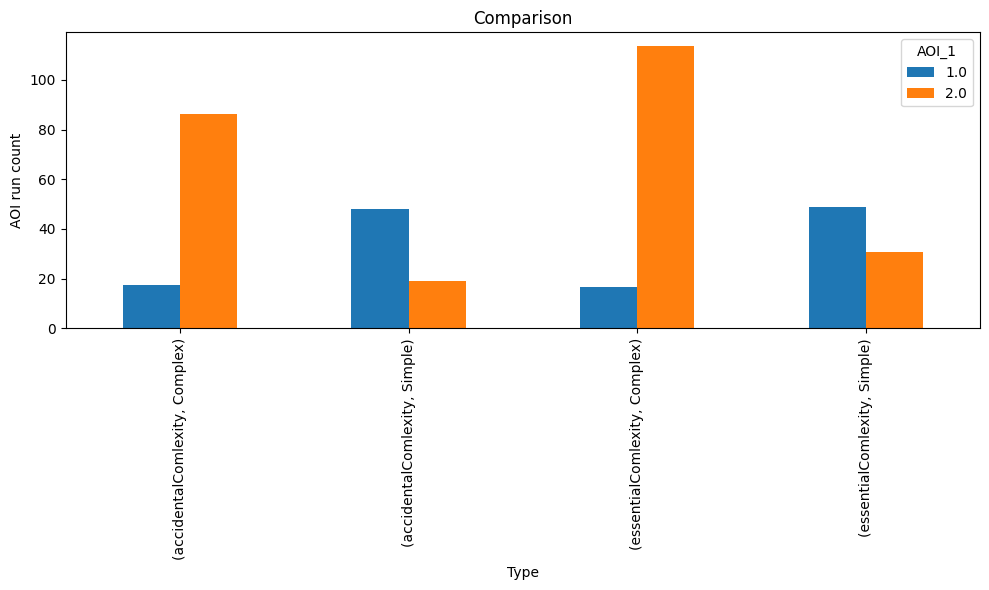

In [22]:
### Compute statistics (Obs1, Obs2)

type3_values = ['essentialComlexity','accidentalComlexity']
type4_values = ['Simple','Complex']
AOI_values = [1,2]

# Obs. 1: diff. of means > 0
# Obs. 2: for simple task, diff is more important than for complex task
# => Show that means are significant
measure = 'AOI run count'
col = 'AOIRunCount'
conditions = [(1,2)]

_df = wholeTaskData.copy(deep=True)

# Compute the means on the relevant- and non-relevant parts
means, grouped_means = compute_grouped_mean(
    df=_df, 
    group_cols=['Type3', 'Type4', 'AOI_1'], group_cols_not_for_overall_mean=['participant', 'currentQuestion'], 
    measure_col=col, measure_type='AOIRunCount',
    additional_filters={})
# Pivot the table
pivot_df = means.pivot_table(index=['Type3','Type4'], columns='AOI_1', values=col)
pivot_df = pivot_df.loc[:, AOI_values]
#display(means)
display(pivot_df)

for type3 in type3_values:
    print(type3)
    for type4 in type4_values:
        print(type4)
        _stat, _p, _n = inference_test(_df,
                                ['participant', 'ComparisionGroup','currentQuestion','Type4','Type3','AOI_1'], 
                                col, 'count',
                                'AOI_1', conditions,
                                additional_filters={
                                    'Type3': type3,
                                    'Type4': type4,
                                    'AOI_1': AOI_values
                                    },
                                do_print=False)
        
        for _i in range(len(conditions)):
            display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                        f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))


comparison_AOIRC = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

AOI_1                             1.0       2.0
Type3               Type4                      
accidentalComlexity Complex  0.190596  0.813216
                    Simple   0.753928  0.251094
essentialComlexity  Complex  0.130903  0.869097
                    Simple   0.646614  0.353386

Type4,Complex,Simple
Type3,,
accidentalComlexity,0.618808,0.505440
essentialComlexity,0.738195,0.397177


essentialComlexity


accidentalComlexity


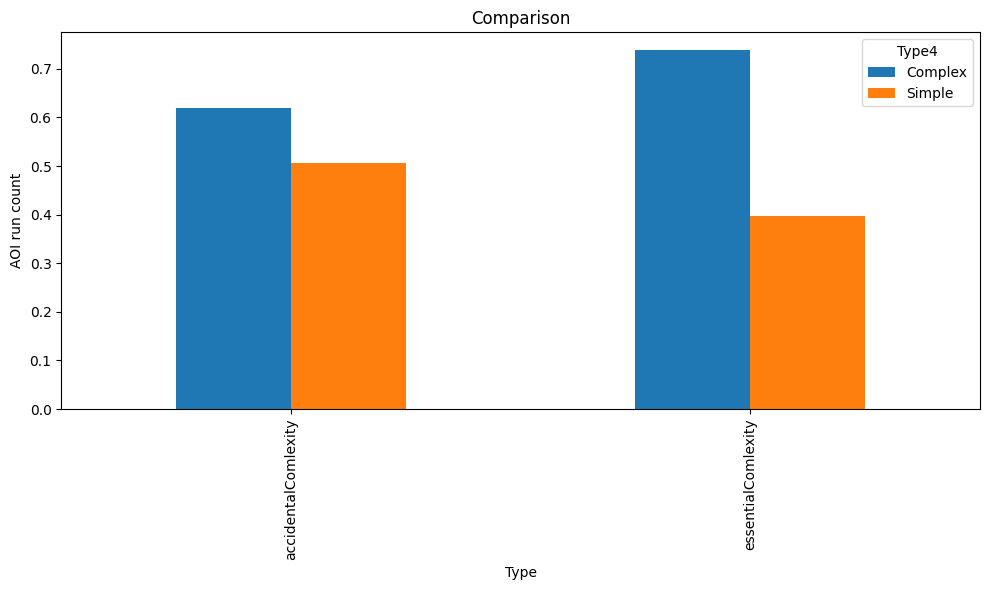

In [23]:
### Test diff. of means (obs 2)
# Assuming the meanse are significantly different, how to test the delta
# value (difference of means from each AOI_1)?
# Use grouped_means to compute the diffrence of means.

col = 'propAOIRunCount'
type3_values = ['essentialComlexity', 'accidentalComlexity']
type4_values = ['Simple', 'Complex']
conditions = [('Simple', 'Complex')]
# /!\ The case AOI_1 = 0 are not taken into account (Eye-Mind hypothesis)
AOI_values = [1, 2]


means1, grouped_means1 = compute_grouped_mean(
    df=_df, 
    group_cols=['Type3', 'Type4', 'AOI_1'], group_cols_not_for_overall_mean=['participant', 'ComparisionGroup','currentQuestion'], 
    measure_col='AOIRunCount', measure_type='prop', measure_type_attr={
        'group_total_cols':['Type3', 'Type4']+['participant', 'currentQuestion'],
        'agg': 'AOIRunCount'
    },
    measure_out=col,
    additional_filters={'AOI_1': AOI_values})

# Pivot the table
pivot_df1 = means1.pivot_table(index=['Type3','Type4'], columns='AOI_1', values=col)
display(pivot_df1)


# /!\ Because AOI 0 was removed, the filters for relevant and non-relevant parts 
# are direct opposite.
_filter = \
    ((grouped_means1.Type4=='Simple') & (grouped_means1.AOI_1==1)) | \
    ((grouped_means1.Type4=='Complex') & (grouped_means1.AOI_1==2))
gm_relevant = grouped_means1.loc[_filter, :]
gm_none_relevant = grouped_means1.loc[~_filter, :]


gmeans = gm_relevant.merge(gm_none_relevant.loc[:,['currentQuestion', 'participant']+[col]], 
                           on=['currentQuestion', 'participant'],
                           left_index=False, right_index=False, 
                           suffixes=('_rel', '_nonrel'))

gmeans['D'] = gmeans[col+'_rel'].subtract(gmeans[col+'_nonrel']).abs()


means, grouped_means = compute_grouped_mean(
    df=gmeans, 
    group_cols=['Type3', 'Type4', 'AOI_1'], group_cols_not_for_overall_mean=['participant', 'ComparisionGroup','currentQuestion'], 
    measure_col='D', measure_type='default', 
    additional_filters={})

# Pivot the table
pivot_df = means.pivot_table(index=['Type3'], columns='Type4', values='D')
#pivot_df = pivot_df.loc[:, AOI_values]
#display(means)
display(pivot_df)

for type3 in type3_values:
    print(type3)
    _group_col = ['participant','ComparisionGroup','currentQuestion','Type3','Type4']
    _stat, _p, _n = inferenceTest(grouped_means, _group_col, 
                              'D', 'mean',
                              'Type4', conditions, _group_col[:2],
                               additional_filters={
                                   'Type3': type3
                                },
                               do_print=False)
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))


comparison_AOIRC = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

AOI_1                             1.0       2.0
Type3               Type4                      
accidentalComlexity Complex  0.190596  0.813216
                    Simple   0.753928  0.251094
essentialComlexity  Complex  0.130903  0.869097
                    Simple   0.646614  0.353386

Type3,accidentalComlexity,essentialComlexity
Type4,,
Complex,0.625850,0.738195
Simple,0.500737,0.397177


Simple


Complex


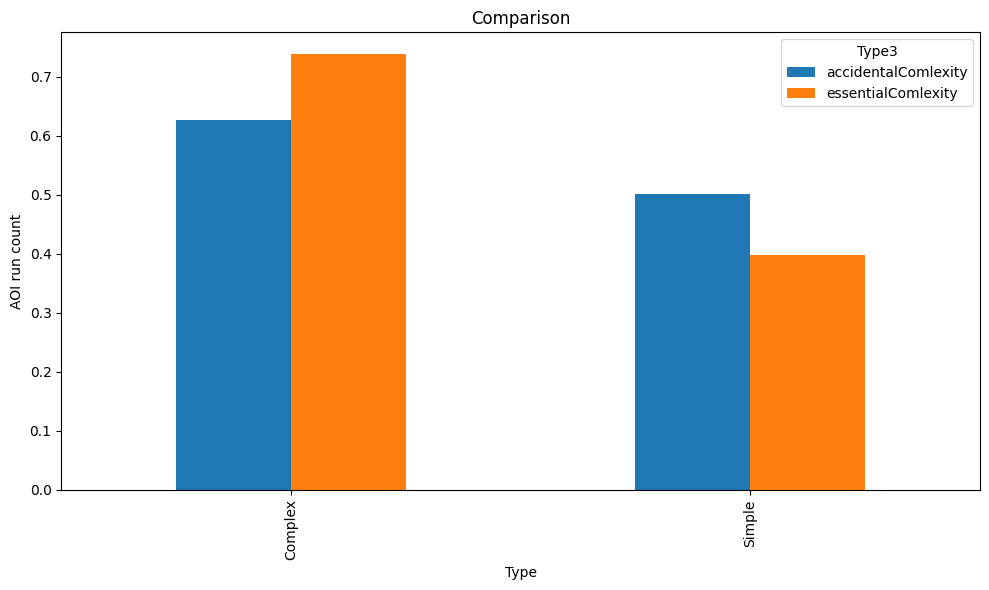

In [24]:
## Display results (Obs3)
#
# Assuming the meanse are significantly different, how to test the delta
# value (difference of means from each AOI_1)?
# Use grouped_means to compute the diffrence of means.

col = 'propAOIRunCount'
type3_values = ['essentialComlexity', 'accidentalComlexity']
type4_values = ['Simple', 'Complex']
conditions = [('essentialComlexity', 'accidentalComlexity')]
# /!\ The case AOI_1 = 0 are not taken into account (Eye-Mind hypothesis)
AOI_values = [1, 2]


means1, grouped_means1 = compute_grouped_mean(
    df=_df, 
    group_cols=['Type3', 'Type4', 'AOI_1'], group_cols_not_for_overall_mean=['participant', 'ComparisionGroup','currentQuestion'], 
    measure_col='AOIRunCount', measure_type='prop', measure_type_attr={
        'group_total_cols':['Type3', 'Type4']+['participant', 'currentQuestion'],
        'agg': 'AOIRunCount'
    },
    measure_out=col,
    additional_filters={'AOI_1': AOI_values})

# Pivot the table
pivot_df1 = means1.pivot_table(index=['Type3','Type4'], columns='AOI_1', values=col)
display(pivot_df1)


# /!\ Because AOI 0 was removed, the filters for relevant and non-relevant parts 
# are direct opposite.
_filter = \
    ((grouped_means1.Type4=='Simple') & (grouped_means1.AOI_1==1)) | \
    ((grouped_means1.Type4=='Complex') & (grouped_means1.AOI_1==2))
gm_relevant = grouped_means1.loc[_filter, :]
gm_none_relevant = grouped_means1.loc[~_filter, :]


gmeans = gm_relevant.merge(gm_none_relevant.loc[:,['currentQuestion', 'participant']+[col]], 
                           on=['currentQuestion', 'participant'],
                           left_index=False, right_index=False, 
                           suffixes=('_rel', '_nonrel'))

gmeans['D'] = gmeans[col+'_rel'].subtract(gmeans[col+'_nonrel']).abs()


means, grouped_means = compute_grouped_mean(
    df=gmeans, 
    group_cols=['Type3', 'Type4', 'AOI_1', 'participant'], group_cols_not_for_overall_mean=[], 
    measure_col='D', measure_type='default', 
    additional_filters={})

# Pivot the table
pivot_df = means.pivot_table(index=['Type4'], columns='Type3', values='D')
#pivot_df = pivot_df.loc[:, AOI_values]
#display(means)
display(pivot_df)

for type4 in type4_values:
    print(type4)
    _group_col = ['participant','Type3','Type4'] # ['participant','ComparisionGroup','currentQuestion','Type3','Type4']
    _stat, _p, _n = inferenceTest(grouped_means, _group_col, 
                              'D', 'mean',
                              'Type3', conditions, _group_col[:1],
                               additional_filters={
                                   'Type4': type4
                                },
                               do_print=False)
    
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))


comparison_AOIRC = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

#### Number of fixations

Long fixations can be related to mental processing (when duration is 250ms < d < 500ms) and also to deep mental processing (when the duration is d < 500ms)

In [25]:
### AVERAGE COUNT OF FIXATIONS WITH DURATION ABOVE THRESOLDS
# (250ms FOR MENTAL PROCESSING, 500 ms FOR DEEP MENTAL PROCESSING)
#

# Keep only MainQuestions for fine grained analysis
fixationData = eifaData2[(eifaData2['Type2'] == 'MainQuestion') & (eifaData2['Type1'] == 'Fine')].copy(deep=True)

# Keep only fixations (select fixation data and drop na)
fixationData = fixationData.loc[(~fixationData['FixID'].isna()) & (~fixationData['currentQuestion'].isna())]

# set fixation threshold
fixationData250 = fixationData[(fixationData['Fixation Duration']>=250) & (fixationData['Fixation Duration']<500)]
fixationData500 = fixationData[fixationData['Fixation Duration']>=500]


## 
# Separate in 3: data for whole task, only the simple part (AOI1=1) and only the complex part (AOI1=2)
wholeTaskData250 = fixationData250.loc[(fixationData250['AOI_1'].isin([0,1,2]))].copy(deep=True)
simpleTaskData250 = fixationData250.loc[(fixationData250['AOI_1'] == 1)].copy(deep=True)
complexTaskData250 = fixationData250.loc[(fixationData250['AOI_1'] == 2)].copy(deep=True)
# Separate in 3: data for whole task, only the simple part (AOI1=1) and only the complex part (AOI1=2)
wholeTaskData500= fixationData500.loc[(fixationData500['AOI_1'].isin([0,1,2]))].copy(deep=True)
simpleTaskData500 = fixationData500.loc[(fixationData500['AOI_1'] == 1)].copy(deep=True)
complexTaskData500 = fixationData500.loc[(fixationData500['AOI_1'] == 2)].copy(deep=True)

'Fix. duration > 250ms'

AOI_1                              1.0        2.0
Type3               Type4                        
accidentalComlexity Complex   3.179487  21.551020
                    Simple    9.571429   4.562500
essentialComlexity  Complex   3.704545  24.367347
                    Simple   10.020408   7.925000

essentialComlexity
Simple


Complex


accidentalComlexity
Simple


Complex


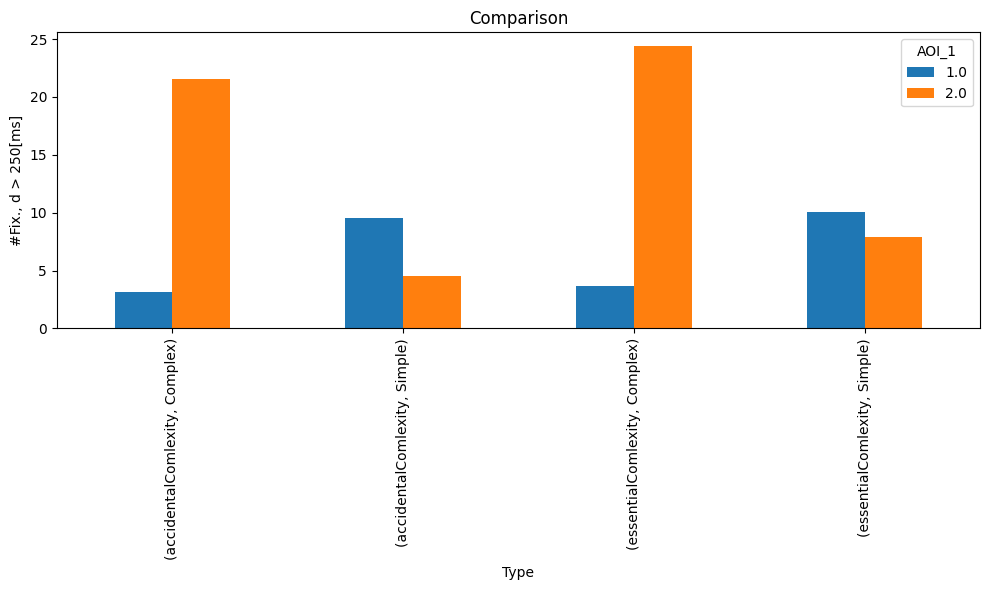

'Fix. duration > 500ms'

AOI_1                             1.0       2.0
Type3               Type4                      
accidentalComlexity Complex  1.000000  6.395349
                    Simple   2.551724  2.076923
essentialComlexity  Complex  1.272727  4.750000
                    Simple   2.588235  1.562500

essentialComlexity
Simple


Complex


accidentalComlexity
Simple


Complex


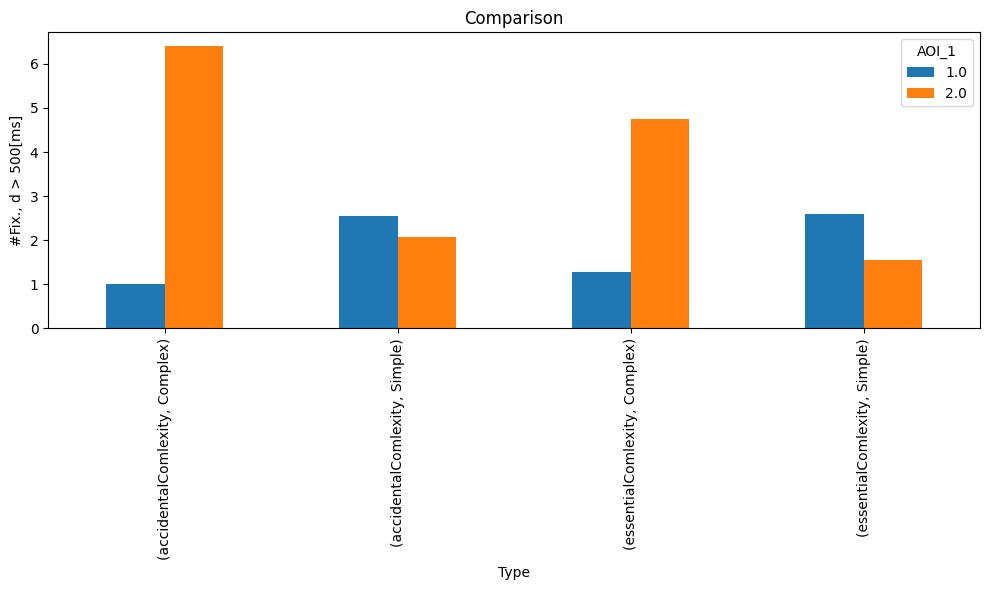

In [26]:
## Display results (Obs 1, Obs2)
_measure250 =  ', d > 250[ms]'
_measure500 =  ', d > 500[ms]'
type3_values = ['essentialComlexity','accidentalComlexity']
type4_values = ['Simple','Complex']
AOI_values = [1,2]

# Obs. 1: diff. of means > 0
# Obs. 2: for complex task, diff is more important than for simple task
# => Show that means are significant
measure = '#Fix.'
col = 'cntFix'
conditions = [(1,2)]

comparison_FixCount = {}


display('Fix. duration > 250ms')
_df = wholeTaskData250
means, _ = compute_grouped_mean(df=_df, 
    group_cols=['Type3', 'Type4', 'AOI_1'], group_cols_not_for_overall_mean=['participant', 'currentQuestion'], 
    measure_col='FixID', measure_type='FixationCount',
    measure_out=col,
    additional_filters={})
pivot_df = means.pivot_table(index=['Type3','Type4'], columns='AOI_1', values=col)
pivot_df = pivot_df.loc[:, AOI_values]
display(pivot_df)

for type3 in type3_values:
    print(type3)
    for type4 in type4_values:
        print(type4)
        _group_cols = ['participant', 'ComparisionGroup','currentQuestion','Type4','Type3','AOI_1']
        _stat, _p, _n = inferenceTest(_df,
            _group_cols, 'FixID', 'count', 
            'AOI_1', conditions, _group_cols[:2], 
            _group_cols[:3],
            additional_filters={
                'Type3': type3,
                'Type4': type4,
                'AOI_1': AOI_values
                },
            do_print=False)
        
        for _i in range(len(conditions)):
            display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                        f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))

comparison_FixCount['procFix'] = {'label': measure + _measure250, 'means': means, 'pivot': pivot_df, 'measure': col}
plotComparison(pivot_df, measure + _measure250)




display('Fix. duration > 500ms')
_df = wholeTaskData500
means, _ = compute_grouped_mean(df=_df, 
    group_cols=['Type3', 'Type4', 'AOI_1'], group_cols_not_for_overall_mean=['participant', 'currentQuestion'], 
    measure_col='FixID', measure_type='FixationCount',
    measure_out=col,
    additional_filters={})
pivot_df = means.pivot_table(index=['Type3','Type4'], columns='AOI_1', values=col)
pivot_df = pivot_df.loc[:, AOI_values]
display(pivot_df)

for type3 in type3_values:
    print(type3)
    for type4 in type4_values:
        print(type4)
        _group_cols = ['participant', 'ComparisionGroup','currentQuestion','Type4','Type3','AOI_1']
        _stat, _p, _n = inferenceTest(_df,
            _group_cols, 'FixID', 'count',  
            'AOI_1', conditions, _group_cols[:2], 
            _group_cols[:3],
            additional_filters={
                'Type3': type3,
                'Type4': type4,
                'AOI_1': AOI_values
                },
            do_print=False)
        
        for _i in range(len(conditions)):
            display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                        f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))

comparison_FixCount['deepFix'] = {'label': measure + _measure500, 'means': means, 'pivot': pivot_df, 'measure': col}
plotComparison(pivot_df, measure + _measure500)


'Fix. duration > 250ms'

AOI_1                             1.0       2.0
Type3               Type4                      
accidentalComlexity Complex  0.170358  0.884817
                    Simple   0.813295  0.285892
essentialComlexity  Complex  0.169597  0.868117
                    Simple   0.683714  0.387451

Type4,Complex,Simple
Type3,,
accidentalComlexity,0.702948,0.456045
essentialComlexity,0.699429,0.440587


essentialComlexity


accidentalComlexity


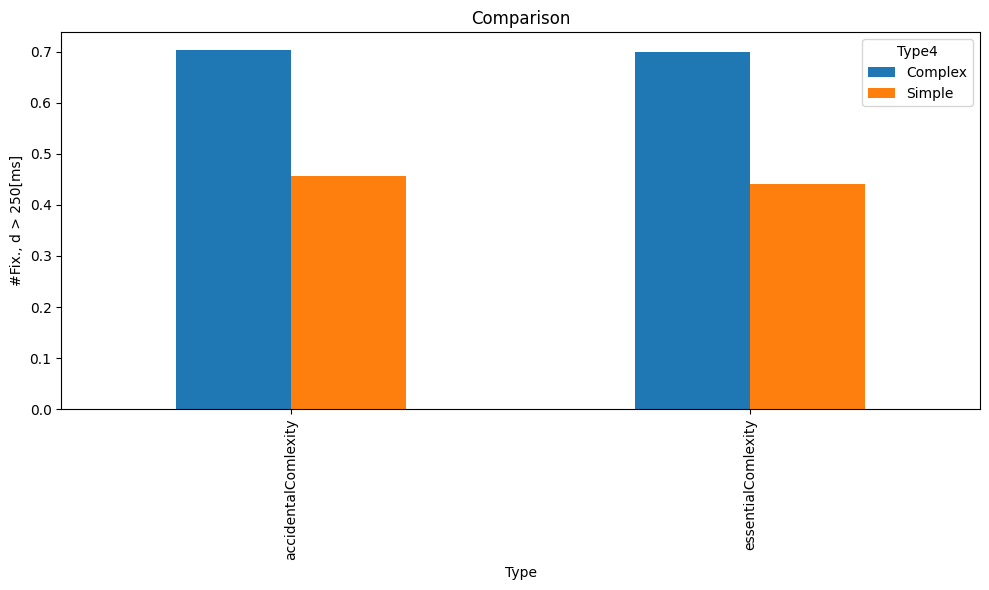

'Fix. duration > 500ms'

AOI_1                             1.0       2.0
Type3               Type4                      
accidentalComlexity Complex  0.102518  0.988079
                    Simple   0.834319  0.523443
essentialComlexity  Complex  0.209964  0.947509
                    Simple   0.862920  0.541295

Type4,Complex,Simple
Type3,,
accidentalComlexity,0.794965,0.187013
essentialComlexity,0.580071,0.334325


essentialComlexity


accidentalComlexity


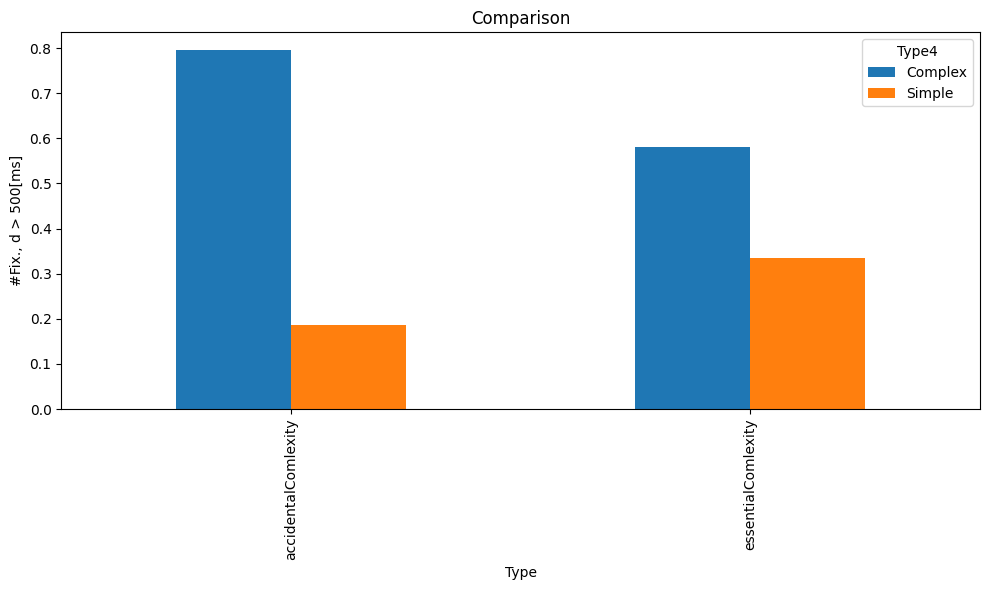

In [27]:
### Test diff. of means (obs 2)
# Assuming the meanse are significantly different, how to test the delta
# value (difference of means from each AOI_1)?
# Use grouped_means to compute the diffrence of means.

col = 'cntFix'
type3_values = ['essentialComlexity','accidentalComlexity']
type4_values = ['Simple','Complex']
conditions = [('Simple', 'Complex')]
# /!\ The case AOI_1 = 0 ust be taken into account to compute the real proportion
AOI_values = [1,2]


display('Fix. duration > 250ms')
_df = wholeTaskData250
means1, grouped_means1 = compute_grouped_mean(
    df=_df, 
    group_cols=['Type3', 'Type4', 'AOI_1'], group_cols_not_for_overall_mean=['participant', 'ComparisionGroup', 'currentQuestion'], 
    measure_col='FixID', measure_type='prop', measure_type_attr={
        'group_total_cols':['Type3', 'Type4']+['participant', 'currentQuestion'],
        'agg': 'FixationCount'
    },
    measure_out=col,
    additional_filters={'AOI_1': AOI_values})
grouped_means1.rename(columns={"FixID": "cntFix"}, inplace=True)

# Pivot the table
pivot_df = means1.pivot_table(index=['Type3','Type4'], columns='AOI_1', values=col)
# pivot_df = pivot_df.loc[type4_values, :]
#display(means)
display(pivot_df)

# /!\ Because AOI 0 was removed, the filters for relevant and non-relevant parts 
# are direct opposite.
_filter = \
    ((grouped_means1.Type4=='Simple') & (grouped_means1.AOI_1==1)) | \
    ((grouped_means1.Type4=='Complex') & (grouped_means1.AOI_1==2))
gm_relevant = grouped_means1.loc[_filter, :]
gm_none_relevant = grouped_means1.loc[~_filter, :]


gmeans = gm_relevant.merge(gm_none_relevant.loc[:,['currentQuestion', 'participant']+[col]], 
                           on=['currentQuestion', 'participant'],
                           left_index=False, right_index=False, 
                           suffixes=('_rel', '_nonrel'))

gmeans['D'] = gmeans[col+'_rel'].subtract(gmeans[col+'_nonrel']).abs()


means, grouped_means = compute_grouped_mean(
    df=gmeans, 
    group_cols=['Type3', 'Type4'], group_cols_not_for_overall_mean=['participant', 'ComparisionGroup', 'currentQuestion'], 
    measure_col='D', measure_type='default', 
    additional_filters={})

# Pivot the table
pivot_df = means.pivot_table(index=['Type3'], columns='Type4', values='D')
#pivot_df = pivot_df.loc[:, AOI_values]
#display(means)
display(pivot_df)


for type3 in type3_values:
    print(type3)
    _group_col = ['participant','ComparisionGroup','currentQuestion','Type3','Type4']
    _stat, _p, _n = inferenceTest(grouped_means, _group_col, 
                              'D', 'mean',
                              'Type4', conditions, _group_col[:2],
                               additional_filters={
                                   'Type3': type3
                                },
                               do_print=False)
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))


comparison_Fix250 = {'label': measure + _measure250, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure+_measure250)












display('Fix. duration > 500ms')
_df = wholeTaskData500
means1, grouped_means1 = compute_grouped_mean(
    df=_df, 
    group_cols=['Type3', 'Type4', 'AOI_1'], group_cols_not_for_overall_mean=['participant', 'ComparisionGroup', 'currentQuestion'], 
    measure_col='FixID', measure_type='prop', measure_type_attr={
        'group_total_cols':['Type3', 'Type4']+['participant', 'currentQuestion'],
        'agg': 'FixationCount'
    },
    measure_out=col,
    additional_filters={'AOI_1': AOI_values})
grouped_means1.rename(columns={"FixID": "cntFix"}, inplace=True)

# Pivot the table
pivot_df = means1.pivot_table(index=['Type3','Type4'], columns='AOI_1', values=col)
display(pivot_df)

# /!\ Because of the AOI 0, the filters for relevant and non-relevant parts 
# are not direct opposite.
_filter = ((grouped_means1.Type4=='Simple') & (grouped_means1.AOI_1==1)) | ((grouped_means1.Type4=='Complex') & (grouped_means1.AOI_1==2))
gm_relevant = grouped_means1.loc[_filter, :]
gm_none_relevant = grouped_means1.loc[~_filter, :]

gmeans = gm_relevant.merge(gm_none_relevant.loc[:,['currentQuestion', 'participant']+[col]], 
                           on=['currentQuestion', 'participant'],
                           left_index=False, right_index=False, suffixes=('_rel', '_nonrel'))
gmeans['D'] = gmeans[col+'_rel'].subtract(gmeans[col+'_nonrel']).abs()

means, grouped_means = compute_grouped_mean(df=gmeans, 
    group_cols=['Type3', 'Type4'], group_cols_not_for_overall_mean=['participant', 'ComparisionGroup', 'currentQuestion'], 
    measure_col='D', measure_type='default', 
    additional_filters={})

# Pivot the table
pivot_df = means.pivot_table(index=['Type3'], columns='Type4', values='D')
#pivot_df = pivot_df.loc[:, AOI_values]
#display(means)
display(pivot_df)


for type3 in type3_values:
    print(type3)
    _group_col = ['participant','ComparisionGroup','currentQuestion','Type3','Type4']
    _stat, _p, _n = inferenceTest(grouped_means, _group_col, 
                                  'D', 'mean',
                                  'Type4', conditions, _group_col[:2],
                                  additional_filters={ 'Type3': type3 },
                                  do_print=False)
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))


comparison_Fix500 = {'label': measure + _measure500, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure+_measure500)




'Fix. duration > 250ms'

AOI_1                             1.0       2.0
Type3               Type4                      
accidentalComlexity Complex  0.170358  0.884817
                    Simple   0.813295  0.285892
essentialComlexity  Complex  0.169597  0.868117
                    Simple   0.683714  0.387451

Type3,accidentalComlexity,essentialComlexity
Type4,,
Complex,0.715171,0.702957
Simple,0.455588,0.434620


Simple


Complex


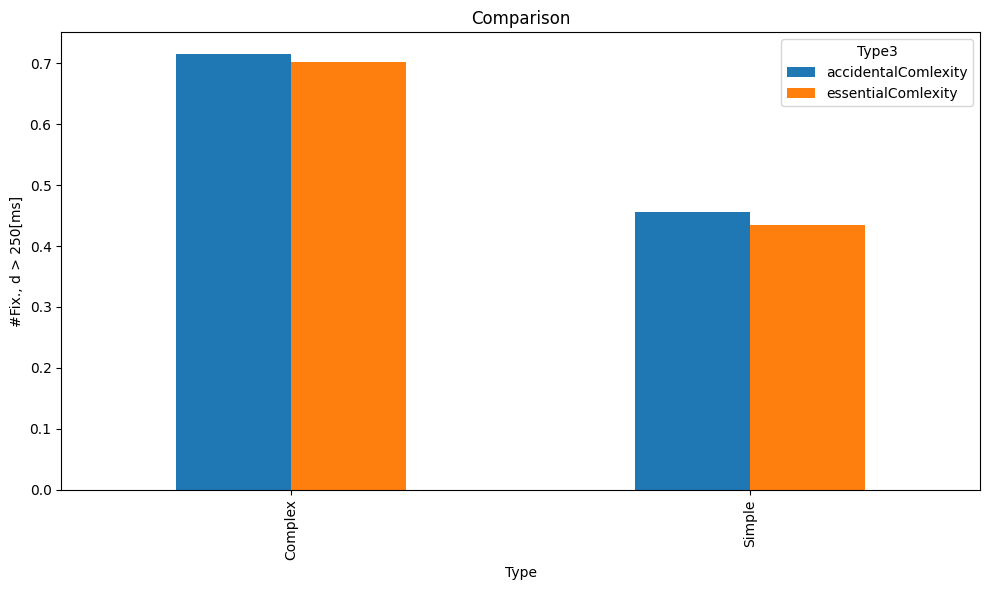

'Fix. duration > 500ms'

AOI_1                             1.0       2.0
Type3               Type4                      
accidentalComlexity Complex  0.102518  0.988079
                    Simple   0.834319  0.523443
essentialComlexity  Complex  0.209964  0.947509
                    Simple   0.862920  0.541295

Type3,accidentalComlexity,essentialComlexity
Type4,,
Complex,0.794965,0.579745
Simple,0.205714,0.384524


Simple


Complex


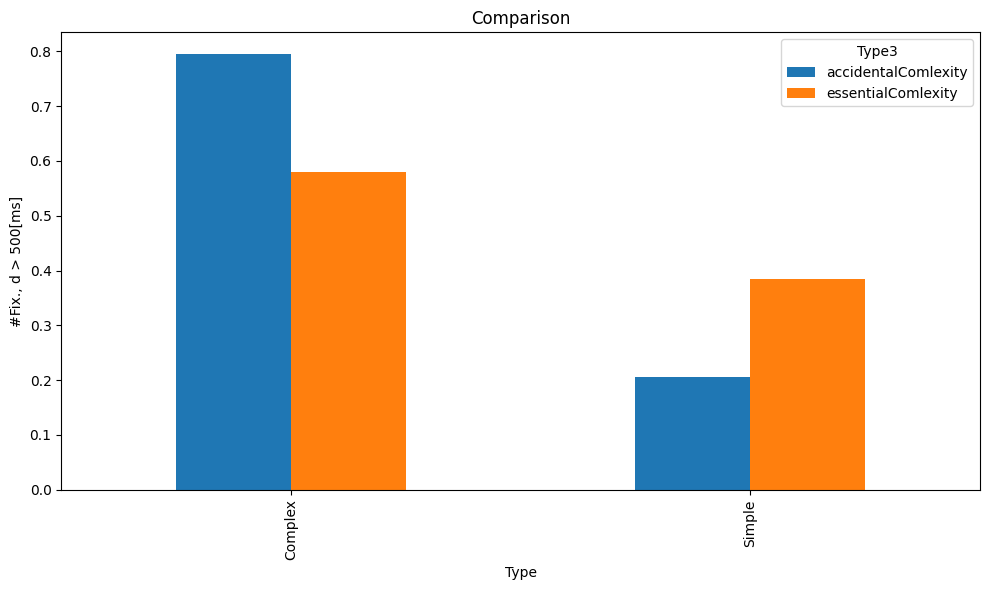

In [28]:
### Display results (obs 3)
# Assuming the meanse are significantly different, how to test the delta
# value (difference of means from each AOI_1)?
# Use grouped_means to compute the diffrence of means.

col = 'cntFix'
type3_values = ['essentialComlexity','accidentalComlexity']
type4_values = ['Simple','Complex']
conditions = [('essentialComlexity','accidentalComlexity')]
# /!\ The case AOI_1 = 0 ust be taken into account to compute the real proportion
AOI_values = [1,2]


display('Fix. duration > 250ms')
_df = wholeTaskData250
means1, grouped_means1 = compute_grouped_mean(
    df=_df, 
    group_cols=['Type3', 'Type4', 'AOI_1'], group_cols_not_for_overall_mean=['participant', 'ComparisionGroup', 'currentQuestion'], 
    measure_col='FixID', measure_type='prop', measure_type_attr={
        'group_total_cols':['Type3', 'Type4']+['participant', 'currentQuestion'],
        'agg': 'FixationCount'
    },
    measure_out=col,
    additional_filters={'AOI_1': AOI_values})
grouped_means1.rename(columns={"FixID": "cntFix"}, inplace=True)

# Pivot the table
pivot_df = means1.pivot_table(index=['Type3','Type4'], columns='AOI_1', values=col)
# pivot_df = pivot_df.loc[type4_values, :]
#display(means)
display(pivot_df)

# /!\ Because AOI 0 was removed, the filters for relevant and non-relevant parts 
# are direct opposite.
_filter = \
    ((grouped_means1.Type4=='Simple') & (grouped_means1.AOI_1==1)) | \
    ((grouped_means1.Type4=='Complex') & (grouped_means1.AOI_1==2))
gm_relevant = grouped_means1.loc[_filter, :]
gm_none_relevant = grouped_means1.loc[~_filter, :]


gmeans = gm_relevant.merge(gm_none_relevant.loc[:,['currentQuestion', 'participant']+[col]], 
                           on=['currentQuestion', 'participant'],
                           left_index=False, right_index=False, 
                           suffixes=('_rel', '_nonrel'))

gmeans['D'] = gmeans[col+'_rel'].subtract(gmeans[col+'_nonrel']).abs()


means, grouped_means = compute_grouped_mean(
    df=gmeans, 
    group_cols=['Type3', 'Type4','participant'], group_cols_not_for_overall_mean=[], 
    measure_col='D', measure_type='default', 
    additional_filters={})

# Pivot the table
pivot_df = means.pivot_table(index=['Type4'], columns='Type3', values='D')
#pivot_df = pivot_df.loc[:, AOI_values]
#display(means)
display(pivot_df)


for type4 in type4_values:
    print(type4)
    _group_col = ['participant','Type3','Type4'] # ['participant','ComparisionGroup','currentQuestion','Type3','Type4']
    _stat, _p, _n = inferenceTest(grouped_means, _group_col, 
                              'D', 'mean',
                              'Type3', conditions, _group_col[:1],
                               additional_filters={
                                   'Type4': type4
                                },
                               do_print=False)
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))


comparison_Fix250 = {'label': measure + _measure250, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure+_measure250)












display('Fix. duration > 500ms')
_df = wholeTaskData500
means1, grouped_means1 = compute_grouped_mean(
    df=_df, 
    group_cols=['Type3', 'Type4', 'AOI_1'], group_cols_not_for_overall_mean=['participant', 'ComparisionGroup', 'currentQuestion'], 
    measure_col='FixID', measure_type='prop', measure_type_attr={
        'group_total_cols':['Type3', 'Type4']+['participant', 'currentQuestion'],
        'agg': 'FixationCount'
    },
    measure_out=col,
    additional_filters={'AOI_1': AOI_values})
grouped_means1.rename(columns={"FixID": "cntFix"}, inplace=True)

# Pivot the table
pivot_df = means1.pivot_table(index=['Type3','Type4'], columns='AOI_1', values=col)
display(pivot_df)

# /!\ Because of the AOI 0, the filters for relevant and non-relevant parts 
# are not direct opposite.
_filter = ((grouped_means1.Type4=='Simple') & (grouped_means1.AOI_1==1)) | ((grouped_means1.Type4=='Complex') & (grouped_means1.AOI_1==2))
gm_relevant = grouped_means1.loc[_filter, :]
gm_none_relevant = grouped_means1.loc[~_filter, :]

gmeans = gm_relevant.merge(gm_none_relevant.loc[:,['currentQuestion', 'participant']+[col]], 
                           on=['currentQuestion', 'participant'],
                           left_index=False, right_index=False, suffixes=('_rel', '_nonrel'))
gmeans['D'] = gmeans[col+'_rel'].subtract(gmeans[col+'_nonrel']).abs()

means, grouped_means = compute_grouped_mean(df=gmeans, 
    group_cols=['Type3', 'Type4','participant'], group_cols_not_for_overall_mean=[], 
    measure_col='D', measure_type='default', 
    additional_filters={})

# Pivot the table
pivot_df = means.pivot_table(index=['Type4'], columns='Type3', values='D')
#pivot_df = pivot_df.loc[:, AOI_values]
#display(means)
display(pivot_df)


for type4 in type4_values:
    print(type4)
    _group_col = ['participant','Type3','Type4'] # ['participant','ComparisionGroup','currentQuestion','Type3','Type4']
    _stat, _p, _n = inferenceTest(grouped_means, _group_col, 
                              'D', 'mean',
                              'Type3', conditions, _group_col[:1],
                               additional_filters={ 'Type4': type4 },
                               do_print=False)
    
    display(HTML(f"<span style='color: {'green' if _p[0] < 0.05 else 'red'};'>" +
                 f"{conditions[0][0]} vs {conditions[0][1]}, N={_n}: p-value = {_p[0]}</span>"))


comparison_Fix500 = {'label': measure + _measure500, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure+_measure500)




#### LHIPA

Related to the physological category of metrics

In [29]:
### LHIPA

pupiFiltered_l = pupiFiltered2[(pupiFiltered2['Type2'] == 'MainQuestion') & (pupiFiltered2['Type1'] == 'Fine')].copy(deep=True)
pupiFiltered_l = pupiFiltered_l[(~pupiFiltered_l['tabName'].isna()) & (~pupiFiltered_l['currentQuestion'].isna())]
pupiFiltered_l = pupiFiltered_l.groupby(['participant', 'currentQuestion','Type1','Type2','Type3','Type4','Type5','ComparisionGroup', 'AOI_1'])

## Compute LHIPA for each group ########################################
# LHIPA is expected to decrease with increased cognitive load
def compute_lhipa(df):
    # Compute LHIPA with default 'sym5' wavelet
    return lhipa(df['pupilSize'], df['Timestamp'])
#
pupiFiltered_l = pupiFiltered_l.apply(compute_lhipa).reset_index()
pupiFiltered_l = pupiFiltered_l.rename(columns={0: 'LHIPA'})


## 
# Separate in 3: data for whole task, only the simple part (AOI1=1) and only the complex part (AOI1=2)
wholeTaskData = pupiFiltered_l.loc[(pupiFiltered_l['AOI_1'].isin([0,1,2]))].copy(deep=True)
simpleTaskData = pupiFiltered_l.loc[(pupiFiltered_l['AOI_1'] == 1)].copy(deep=True)
complexTaskData = pupiFiltered_l.loc[(pupiFiltered_l['AOI_1'] == 2)].copy(deep=True)

c:\DEV\NASSY\nassy-eyemind_plus-beta\utils\lhipa_utils.py:67: UserWarning: Input signal size (=30) lower than the minimum (=100). Returned NaN.
  warn(f'Input signal size (={len(d)}) lower than the minimum (={min_sample_size}). Returned NaN.')
c:\DEV\NASSY\nassy-eyemind_plus-beta\utils\lhipa_utils.py:67: UserWarning: Input signal size (=69) lower than the minimum (=100). Returned NaN.
  warn(f'Input signal size (={len(d)}) lower than the minimum (={min_sample_size}). Returned NaN.')
c:\DEV\NASSY\nassy-eyemind_plus-beta\utils\lhipa_utils.py:67: UserWarning: Input signal size (=58) lower than the minimum (=100). Returned NaN.
  warn(f'Input signal size (={len(d)}) lower than the minimum (={min_sample_size}). Returned NaN.')
c:\DEV\NASSY\nassy-eyemind_plus-beta\utils\lhipa_utils.py:67: UserWarning: Input signal size (=66) lower than the minimum (=100). Returned NaN.
  warn(f'Input signal size (={len(d)}) lower than the minimum (={min_sample_size}). Returned NaN.')
c:\DEV\NASSY\nassy-eyemi

AOI_1                             1.0       2.0
Type3               Type4                      
accidentalComlexity Complex  0.314996  0.596321
                    Simple   0.619337  0.351894
essentialComlexity  Complex  0.218751  0.420193
                    Simple   0.473869  0.359072

essentialComlexity


accidentalComlexity


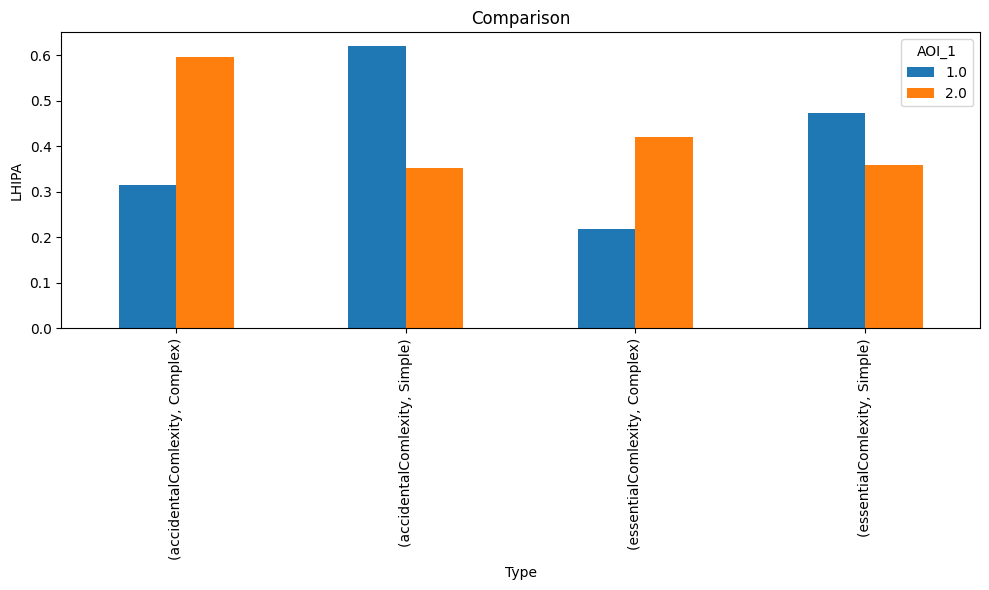

In [30]:
## Display results (Obs 1, Obs2)
type3_values = ['essentialComlexity','accidentalComlexity']
type4_values = ['Simple','complex']
AOI_values = [1,2]

# Obs. 1: diff. of means > 0
# Obs. 2: for simple task, diff is more important than for complex task
# => Show that means are significant
measure = 'LHIPA'
col = 'LHIPA'
conditions = [(1,2)]

comparison_LHIPA = {}

_df = wholeTaskData

means, _ = compute_grouped_mean(df=_df, 
    group_cols=['Type3', 'Type4', 'AOI_1'], group_cols_not_for_overall_mean=['participant', 'currentQuestion'], 
    measure_col=col,
    additional_filters={})
pivot_df = means.pivot_table(index=['Type3','Type4'], columns='AOI_1', values=col)
pivot_df = pivot_df.loc[:, AOI_values]
display(pivot_df)

for type3 in type3_values:
    print(type3)
    _group_col = ['participant', 'ComparisionGroup','currentQuestion','Type4','Type3','AOI_1']
    _stat, _p, _n = inferenceTest(_df, _group_col, 
        col, 'count',  'AOI_1', conditions, _group_col[:2], _group_col[:3],
        additional_filters={
            'Type3': type3,
            'AOI_1': AOI_values
            },
        do_print=False)
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))

comparison_LHIPA['Obs2'] = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}
plotComparison(pivot_df, measure)


Type4,Complex,Simple
Type3,,
accidentalComlexity,0.585801,0.607636
essentialComlexity,0.638143,0.553399


essentialComlexity


accidentalComlexity


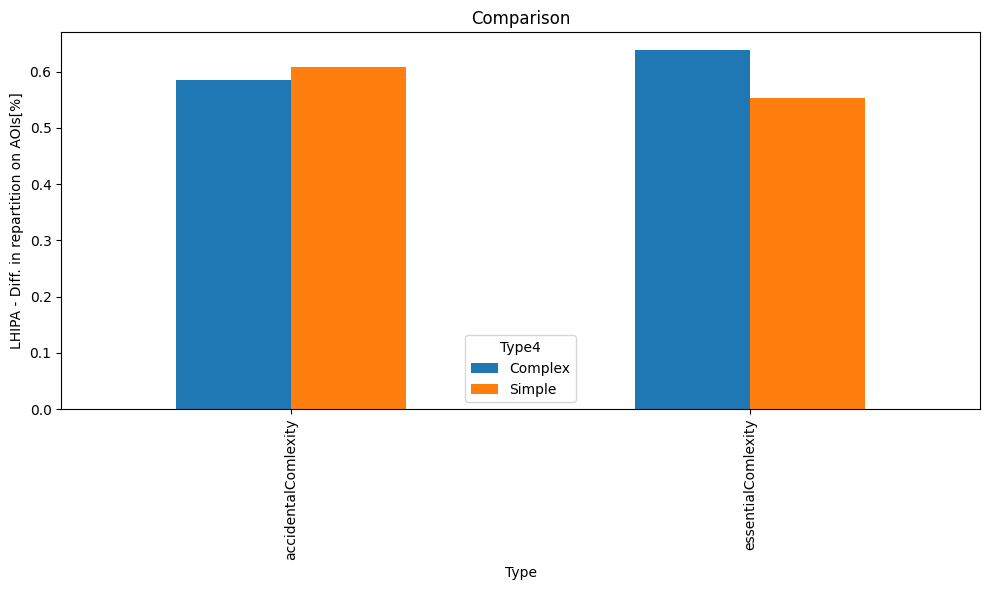

In [31]:
## Display results
measure = 'LHIPA - Diff. in repartition on AOIs[%]'
col = 'LHIPA_Diff'
type3_values = ['essentialComlexity','accidentalComlexity']
AOI_values = [0,1, 2]
conditions = [('Simple','Complex')]


# Compute the difference in percentage between means from(spatial) AOIs
_cols = ['participant','currentQuestion','Type1','Type3','Type4','Type5','ComparisionGroup', 'AOI_1']
_df = simpleTaskData.groupby(_cols)[['LHIPA']].mean().reset_index()
_df2 = complexTaskData.groupby(_cols)[['LHIPA']].mean().reset_index()
_df['LHIPA_AOI_2'] = _df2['LHIPA']
_diffLHIPA = _df['LHIPA'].sub(_df2['LHIPA'], fill_value=0).abs()
_totLHIPA = _df['LHIPA'].add(_df2['LHIPA'], fill_value=0)
_df[col] = _diffLHIPA/_totLHIPA


# Whole models
means, _ = compute_grouped_mean(df=_df, 
    group_cols=['Type3','Type4'], group_cols_not_for_overall_mean=['participant', 'currentQuestion'], 
    measure_col=col,
    additional_filters={})
# Pivot the table
pivot_df = means.pivot_table(index=['Type3'], columns=['Type4'], values=col)
# pivot_df = pivot_df.loc[:, type3_values]
display(pivot_df)

for type3 in type3_values:
    print(type3)
    _group_col = ['participant', 'ComparisionGroup','currentQuestion','Type4','Type3']
    _stat, _p, _n = inferenceTest(_df, _group_col,
                               col, 'mean', 
                               'Type4', conditions, _group_col[:2], _group_col[:3],
                               additional_filters={'Type3': type3},
                               do_print=False)
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))
    
comparison_lhipa = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

In [32]:
### Store DataFrames - Pickling
PKL_DIR = DATA_DIR + 'pkl3'
PKL_SUFF = 'Space-Analysis'

if not os.path.isdir(PKL_DIR):
    os.mkdir(PKL_DIR)

eifaData.to_pickle(PKL_DIR + r'\eifaData'+ PKL_SUFF + '.pkl')
perceivedDifficultyData.to_pickle(PKL_DIR + r'\perceivedDifficultyData'+ PKL_SUFF + '.pkl')
answersData.to_pickle(PKL_DIR + r'\answersData'+ PKL_SUFF + '.pkl')
questionsFileParsed.to_pickle(PKL_DIR + r'\questionsFileParsed'+ PKL_SUFF + '.pkl')
eyeMindFullData.to_pickle(PKL_DIR + r'\eyeMindFullData'+ PKL_SUFF + '.pkl')
pupiFiltered.to_pickle(PKL_DIR + r'\pupiFiltered'+ PKL_SUFF + '.pkl')


demogData.to_pickle(PKL_DIR + r'\demogData'+ PKL_SUFF + '.pkl')
eifaData2.to_pickle(PKL_DIR + r'\eifaData2'+ PKL_SUFF + '.pkl')
perceivedDifficultyData2.to_pickle(PKL_DIR + r'\perceivedDifficultyData2'+ PKL_SUFF + '.pkl')
answersData2.to_pickle(PKL_DIR + r'\answersData2'+ PKL_SUFF + '.pkl')
pupiFiltered2.to_pickle(PKL_DIR + r'\pupiFiltered2'+ PKL_SUFF + '.pkl')


aoircData.to_pickle(PKL_DIR + r'\aoircData'+ PKL_SUFF + '.pkl')

In [33]:
### Load DataFrames - Pickling
PKL_DIR = DATA_DIR + 'pkl3'
PKL_SUFF = 'Space-Analysis'

_get_pickle = lambda f: pd.read_pickle(PKL_DIR + f+ PKL_SUFF + '.pkl')

if os.path.isdir(PKL_DIR):
    eifaData = _get_pickle(r'\eifaData')
    perceivedDifficultyData = _get_pickle(r'\perceivedDifficultyData')
    answersData = _get_pickle(r'\answersData')
    questionsFileParsed = _get_pickle(r'\questionsFileParsed')
    eyeMindFullData = _get_pickle(r'\eyeMindFullData')
    pupiFiltered = _get_pickle(r'\pupiFiltered')

    demogData = _get_pickle(r'\demogData')
    eifaData2 = _get_pickle(r'\eifaData2')
    pupiFiltered2 = _get_pickle(r'\pupiFiltered2')
    perceivedDifficultyData2 = _get_pickle(r'\perceivedDifficultyData2')
    answersData2 = _get_pickle(r'\answersData2')

    aoircData = _get_pickle(r'\aoircData')

### Fine-grained in time only

Show the distribution of cognitive load (long fixations)/attention (all fixations) in discovery and post-discovery phases.

Show evolution of estimators (with discovery and post-discovery phases) => fine-grained in time only.

In [34]:
### Prepare fixation data
_base_filter = (eifaData['Type2'] == 'MainQuestion')
allTaskFixData = eifaData2.loc[_base_filter & (~eifaData2['FixID'].isna())].copy(deep=True)

_base_filter = (eifaData['Type2'] == 'MainQuestion') & (eifaData['Type1'] == 'Fine')
fixData = eifaData2.loc[_base_filter & (~eifaData2['FixID'].isna())].copy(deep=True)

_base_filter = (pupiFiltered2['Type2'] == 'MainQuestion') & (pupiFiltered2['Type1'] == 'Fine')
pupData = pupiFiltered2[_base_filter & (~pupiFiltered2['tabName'].isna())].copy(deep=True)


# set fixation threshold
fixData250 = fixData[(fixData['Fixation Duration']>=250) & (fixData['Fixation Duration']<500)].copy(deep=True)
_measure250 =  ', d > 250[ms] (mental processing)'
fixData500 = fixData[fixData['Fixation Duration']>=500].copy(deep=True)
_measure500 =  ', d > 500[ms] (deep mental processing)'


## 
# Process all fixation as well as fixation associated with shallow and deep mental processing
wholeTaskData = fixData.loc[(fixData['AOI_2'].isin([1, 2]))].copy(deep=True)
allFix = fixData.loc[
    (fixData['AOI_1'].isin([1, 2])) & (fixData['AOI_2'].isin([1, 2]))].copy(deep=True)
procFix = fixData250.loc[
    (fixData250['AOI_1'].isin([1, 2])) & (fixData250['AOI_2'].isin([1, 2]))].copy(deep=True)
deepProcFix = fixData500.loc[
    (fixData500['AOI_1'].isin([1, 2])) & (fixData500['AOI_2'].isin([1, 2]))].copy(deep=True)
# wholeTaskData250 = fixData250.loc[(fixData250['AOI_2'].isin([1, 2]))].copy(deep=True)
# wholeTaskData500 = fixData500.loc[(fixData500['AOI_2'].isin([1, 2]))].copy(deep=True)
# discoveryData = fixData.loc[(fixData['AOI_2'] == 1)].copy(deep=True)
# postdiscoveryData = fixData.loc[(fixData['AOI_2'] == 2)].copy(deep=True)


In [35]:
## Display results
# 
# measure = '#Fix.'
col = 'FixID'
# type3_values = ['essentialComlexity','accidentalComlexity']
# type5_values = ['ComposedSimple', 'ComposedComplex']
# conditions = [('ComposedSimple', 'ComposedComplex')]

display('Fixations:')

display('ALL')
means = {}
means['whole'], _ = compute_grouped_mean(df=wholeTaskData, 
    group_cols=['Type3', 'Type5', 'AOI_2'], group_cols_not_for_overall_mean=['participant','currentQuestion'], 
    measure_col=col, measure_out='cntFix',
    measure_type='FixationCount',
    additional_filters={})
# Pivot the table
pivot_df = means['whole'].pivot_table(index=['Type3','Type5'], columns=['AOI_2'], values='cntFix')
display(pivot_df)
means['all'], _ = compute_grouped_mean(df=allFix, 
    group_cols=['Type3', 'Type5', 'AOI_1', 'AOI_2'], group_cols_not_for_overall_mean=['participant','currentQuestion'], 
    measure_col=col, measure_out='cntFix',
    measure_type='FixationCount',
    additional_filters={})
# Pivot the table
pivot_df = means['all'].pivot_table(index=['Type3','Type5', 'AOI_1'], columns=['AOI_2'], values='cntFix')
display(pivot_df)

display('Mental processing fixations')
means['proc'], _ = compute_grouped_mean(df=procFix, 
    group_cols=['Type3', 'Type5', 'AOI_1', 'AOI_2'], group_cols_not_for_overall_mean=['participant', 'currentQuestion'], 
    measure_col=col, measure_out='cntFix',
    measure_type='FixationCount',
    additional_filters={})
# Pivot the table
pivot_df = means['proc'].pivot_table(index=['Type3','Type5', 'AOI_1'], columns=['AOI_2'], values='cntFix')
display(pivot_df)

display('Deep mental processing fixations')
means['deep'], _ = compute_grouped_mean(df=deepProcFix, 
    group_cols=['Type3', 'Type5', 'AOI_1', 'AOI_2'], group_cols_not_for_overall_mean=['participant', 'currentQuestion'], 
    measure_col=col, measure_out='cntFix',
    measure_type='FixationCount',
    additional_filters={})
# Pivot the table
pivot_df = means['deep'].pivot_table(index=['Type3','Type5', 'AOI_1'], columns=['AOI_2'], values='cntFix')
display(pivot_df)

'Fixations:'

'ALL'

AOI_2                                     1       2
Type3               Type5                          
accidentalComlexity ComposedComplex   80.50  235.64
                    ComposedSimple    81.58  135.62
essentialComlexity  ComposedComplex  172.66  309.22
                    ComposedSimple   155.68  142.48

AOI_2                                              1          2
Type3               Type5           AOI_1                      
accidentalComlexity ComposedComplex 1.0    16.306122   7.444444
                                    2.0    12.183673  93.640000
                    ComposedSimple  1.0    18.632653  38.520000
                                    2.0    11.809524  17.114286
essentialComlexity  ComposedComplex 1.0    15.060000   9.217391
                                    2.0    46.520000  85.560000
                    ComposedSimple  1.0    21.960000  36.600000
                                    2.0    29.060000  10.258065

'Mental processing fixations'

AOI_2                                             1          2
Type3               Type5           AOI_1                     
accidentalComlexity ComposedComplex 1.0    2.611111   1.875000
                                    2.0    2.676471  19.693878
                    ComposedSimple  1.0    3.238095   7.400000
                                    2.0    3.210526   4.047619
essentialComlexity  ComposedComplex 1.0    3.076923   3.071429
                                    2.0    8.042553  17.361702
                    ComposedSimple  1.0    4.488372   6.340426
                                    2.0    7.388889   3.000000

'Deep mental processing fixations'

AOI_2                                             1         2
Type3               Type5           AOI_1                    
accidentalComlexity ComposedComplex 1.0    1.000000  1.000000
                                    2.0    1.153846  6.500000
                    ComposedSimple  1.0    1.076923  2.222222
                                    2.0    1.200000  2.333333
essentialComlexity  ComposedComplex 1.0    1.000000  2.500000
                                    2.0    1.727273  4.071429
                    ComposedSimple  1.0    1.428571  2.230769
                                    2.0    1.333333  1.300000

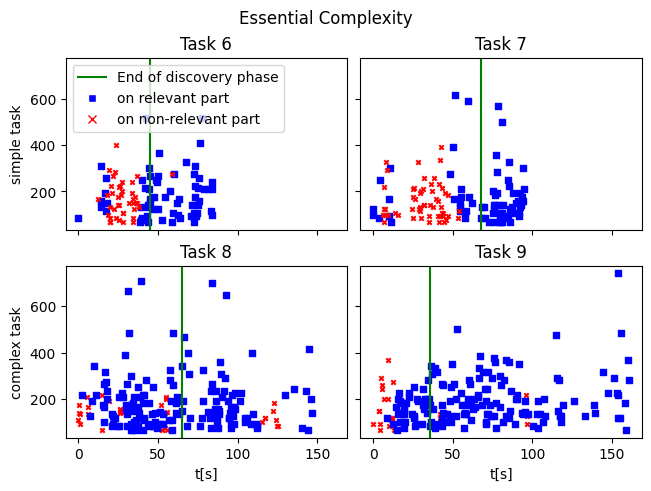

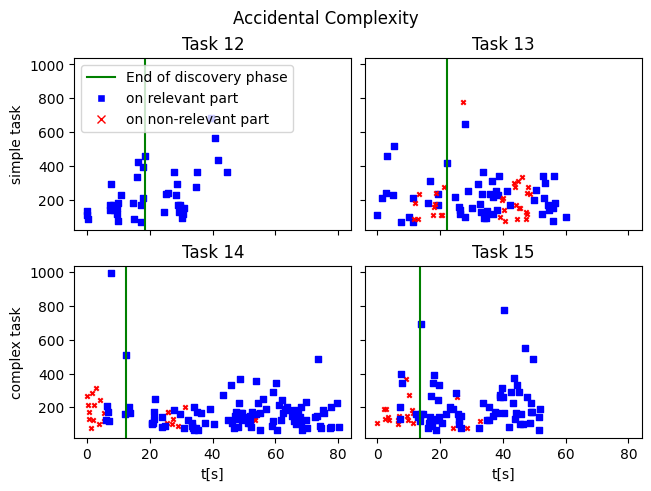

In [36]:
## Visualizations

_pID = participantIDs[8]
_tID = taskIDs[6] # taskIDs[i] => qIDs[i]
_df = allFix.copy(deep=True)
_df_ans = answersData2.copy(deep=True)

def _fscatter(ax, pID, tID, qID, df, xlabel=None, ylabel=None, legendlabels='simple'):
    df = df.loc[(_df.ParticipantID==pID) & (df.TaskId==tID),:].copy(deep=True)
    if df.empty: return

    ts = df.Timestamp.values
    ts0 = ts[0]

    labels=['on relevant part', 'on non-relevant parts']
    c1, s1, m1 = ['b', 20, 's']
    c2, s2, m2 = ['r', 10, 'x']
    if legendlabels == 'complex':
        labels=['on non-relevant parts', 'on relevant part']
        c1, s1, m1 = ['r', 10, 'x']
        c2, s2, m2 = ['b', 20, 's']

    Y1 = df.loc[df['AOI_1']==1]
    if Y1.size > 0:
        Y11 = Y1.loc[Y1['AOI_2']==1]
        if not(Y11.empty):
            ts11 = Y11.Timestamp.values-ts0
            ax.scatter(ts11/1000, Y11['Fixation Duration'], s=s1, c=c1, marker=m1, label=labels[0])

        Y12 = Y1.loc[Y1['AOI_2']==2]
        if not(Y12.empty):
            ts12 = Y12.Timestamp.values-ts0
            ax.scatter(ts12/1000, Y12['Fixation Duration'], s=s1, c=c1, marker=m1, label=labels[0])

        
        # ts1 = Y1.Timestamp.values-ts0
        # ax.scatter(ts1/1000, Y1['Fixation Duration'], s=10, c=c1, marker="s", label=labels[0])
        # #
        # # ax.legend should be called only if some data is scattered.
        # ax.legend(loc='upper left')

    Y2 = df.loc[df['AOI_1']==2]
    if Y2.size > 0:
        Y21 = Y2.loc[Y2['AOI_2']==1]
        if not(Y21.empty):
            ts21 = Y21.Timestamp.values-ts0
            ax.scatter(ts21/1000, Y21['Fixation Duration'], s=s2, c=c2, marker=m2, label=labels[1])

        Y22 = Y2.loc[Y2['AOI_2']==2]
        if not(Y22.empty):
            ts22 = Y22.Timestamp.values-ts0
            ax.scatter(ts22/1000, Y22['Fixation Duration'], s=s2, c=c2, marker=m2, label=labels[1])

        
        # ts2 = Y2.Timestamp.values-ts[0]
        # ax.scatter(ts2/1000, Y2['Fixation Duration'], s=10, c=c2, marker="o", label=labels[1])
        # #
        # # # ax.legend should be called only if some data is scattered.
        # ax.legend(loc='upper left')


    tsDiscoveryPhase = _df_ans.loc[(answersData2['participant'] == pID) & \
            (answersData['questionID'] == qID), 'tsDiscoveryPhase']
    if not tsDiscoveryPhase.empty:
        tsDiscoveryPhase = tsDiscoveryPhase.values[0] - ts0
        ax.axvline(tsDiscoveryPhase/1000, color = 'g', label = 'End of discovery phase')

    ax.set_title(f'Task {tID}')
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)


legend_elements = [
    matplotlib.lines.Line2D([0], [0], color='g', label='End of discovery phase'),
    matplotlib.lines.Line2D([0], [0], marker='s', color='w', markerfacecolor='b', label='on relevant part'),
    matplotlib.lines.Line2D([0], [0], marker='x', color='w', markeredgecolor='r', label='on non-relevant part')
    ]

fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, sharex=True, sharey=True, layout="constrained")
fig.suptitle('Essential Complexity')
_fscatter(ax11, _pID, taskIDs[0], qIDs[0], _df, ylabel='simple task'), ax11.legend(handles=legend_elements, loc='upper left')
_fscatter(ax12, _pID, taskIDs[1], qIDs[1], _df)
_fscatter(ax21, _pID, taskIDs[2], qIDs[2], _df, xlabel='t[s]', ylabel='complex task', legendlabels='complex')
_fscatter(ax22, _pID, taskIDs[3], qIDs[3], _df, xlabel='t[s]', legendlabels='complex')


_f = IMG_DIR + r'/fine_grained_analysis2_repartition_fixations_ess' + _pID + '.png'
plt.savefig(_f, dpi=300)
plt.show()





fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, sharex=True, sharey=True, layout="constrained")
fig.suptitle('Accidental Complexity')
_fscatter(ax11, _pID, taskIDs[4], qIDs[4], _df, ylabel='simple task'), ax11.legend(handles=legend_elements, loc='upper left')
_fscatter(ax12, _pID, taskIDs[5], qIDs[5], _df)
_fscatter(ax21, _pID, taskIDs[6], qIDs[6], _df, xlabel='t[s]', ylabel='complex task', legendlabels='complex')
_fscatter(ax22, _pID, taskIDs[7], qIDs[7], _df, xlabel='t[s]', legendlabels='complex')

_f = IMG_DIR + r'/fine_grained_analysis2_repartition_fixations_acc' + _pID + '.png'
plt.savefig(_f, dpi=300)
plt.show()




In [37]:
### Prepare AOI Run Count data
_base_filter = (aoircData['Type2'] == 'MainQuestion') & (aoircData['Type1'] == 'Fine')
f_aoircData = aoircData.loc[_base_filter].copy(deep=True)


## Display results
# 
# measure = '#Fix.'
col = 'AOIRunCount'
# type3_values = ['essentialComlexity','accidentalComlexity']
# type5_values = ['ComposedSimple', 'ComposedComplex']
# conditions = [('ComposedSimple', 'ComposedComplex')]

display('AOI Run Count:')

means['aoirc'], grouped_means = compute_grouped_mean(df=f_aoircData, 
    group_cols=['Type3', 'Type5', 'AOI_2'], group_cols_not_for_overall_mean=['participant','currentQuestion'], 
    measure_col=col, measure_out='cntAOIRC',
    measure_type='AOIRunCount',
    additional_filters={})
# Pivot the table
pivot_df = means['aoirc'].pivot_table(index=['Type3','Type5'], columns=['AOI_2'], values='cntAOIRC')
display(pivot_df)


'AOI Run Count:'

AOI_2                                  1.0     2.0
Type3               Type5                         
accidentalComlexity ComposedComplex  41.98  137.34
                    ComposedSimple   44.58   77.28
essentialComlexity  ComposedComplex  94.20  147.54
                    ComposedSimple   80.34   75.96

### Non-task-relevant parts of models: "noise"

For the given context of a task, the term 'noise' refers to the part of the model that is not relevant for the correct execution of the task.
Measure of metrics applied on the noise, referred to as measure of noise, can be compared to measure of metric applied to task-relevant part of the model.



In [38]:
## Add 'noise' flag
###############################################################################
# to substantiate further (either most noise occurred at search or some noise 
# occurred at inference in essential complexity)

# From the preparation of fixation data
# wholeTaskData = fixData by AOI_1
# allFix = fixData by AOI_1 and AOI_2
# procFix = fixData250 by AOI_1 and AOI_2
# deepProcFix = fixData500 by AOI_1 and AOI_2

s_aoi = {'none':0, 'simple':1, 'complex':2}
t_aoi = {'disc':1, 'pdisc':2}

type3_values = ['essentialComlexity', 'accidentalComlexity']
type5_values = ['ComposedSimple', 'ComposedComplex']
aoi_1_values = [1,2]
aoi_2_values = [1,2]


# NOISE: fixations that landed on the non relevant part of the model for a 
# given task.
# 1. Generate filters to find (a) noise in simple tasks and (b) noise in complex 
#   task.
_filter = lambda df: \
    ((df['Type5']==type5_values[0]) & (df['AOI_1']!=s_aoi['simple'])) | \
    ((df['Type5']==type5_values[1]) & (df['AOI_1']!=s_aoi['complex']))
# 2. Apply filter
#   2.1. Add flag column
allTaskFixData['noise'] = False
#   2.2. Set the flag for noise according to the generated filter.
allTaskFixData.loc[_filter(allTaskFixData), 'noise'] = True
# 3. Repeat for wholeTaskData, allFix, procFix and deepProcFix.
wholeTaskData['noise'] = False
wholeTaskData.loc[_filter(wholeTaskData), 'noise'] = True
allFix['noise'] = False
allFix.loc[_filter(allFix), 'noise'] = True
procFix['noise'] = False
procFix.loc[_filter(procFix), 'noise'] = True
deepProcFix['noise'] = False
deepProcFix.loc[_filter(deepProcFix), 'noise'] = True
#
# 4. Same process for AOI Run Count data
f_aoircData['noise'] = False
f_aoircData.loc[_filter(f_aoircData), 'noise'] = True


In [39]:
## Proportion of noise
#
# From the preparation of fixation data
# wholeTaskData = fixData by AOI_1
# allFix = fixData by AOI_1 and AOI_2
# procFix = fixData250 by AOI_1 and AOI_2
# deepProcFix = fixData500 by AOI_1 and AOI_2

col = 'FixID'
aoi_1_values = [1,2]

means = {}
gmeans = {}

display('Compute means for the whole task (no temporal AOIs), on ...')
# For all fixations
display('all fixations: "all"')
_df = allFix.copy(deep=True)
means['all'], gmeans['all'] = compute_grouped_mean(df=_df, 
    group_cols=['Type3','AOI_1','noise'], group_cols_not_for_overall_mean=['participant', 'currentQuestion'], 
    measure_col=col, measure_type='prop', measure_type_attr={'group_total_cols':['Type3']+['participant', 'currentQuestion']},
    additional_filters={'AOI_1': aoi_1_values})
# display(gmeans['all'])
# display(means['all'])

display('mental processing fixations: "proc"')
_df = procFix.copy(deep=True)
means['proc'], gmeans['proc'] = compute_grouped_mean(df=_df, 
    group_cols=['Type3','AOI_1','noise'], group_cols_not_for_overall_mean=['participant', 'currentQuestion'], 
    measure_col=col, measure_type='prop', measure_type_attr={'group_total_cols':['Type3']+['participant', 'currentQuestion']},
    additional_filters={'AOI_1': aoi_1_values})


display('deep mental processing fixations: "deep"')
_df = deepProcFix.copy(deep=True)
means['deep'], gmeans['deep'] = compute_grouped_mean(df=_df, 
    group_cols=['Type3','AOI_1','noise'], group_cols_not_for_overall_mean=['participant', 'currentQuestion'], 
    measure_col=col, measure_type='prop', measure_type_attr={'group_total_cols':['Type3']+['participant', 'currentQuestion']},
    additional_filters={'AOI_1': aoi_1_values})


display('AOI Run Count: "aoirc"')

col = 'AOIRunCount'

_df = f_aoircData.copy(deep=True)
means['aoirc'], gmeans['aoirc'] = compute_grouped_mean(df=_df, 
    group_cols=['Type3','AOI_1','noise'], group_cols_not_for_overall_mean=['participant', 'currentQuestion'], 
    measure_col=col, measure_type='prop', measure_type_attr={'group_total_cols':['Type3']+['participant', 'currentQuestion']},
    additional_filters={'AOI_1': aoi_1_values})


'Compute means for the whole task (no temporal AOIs), on ...'

'all fixations: "all"'

'mental processing fixations: "proc"'

'deep mental processing fixations: "deep"'

'AOI Run Count: "aoirc"'

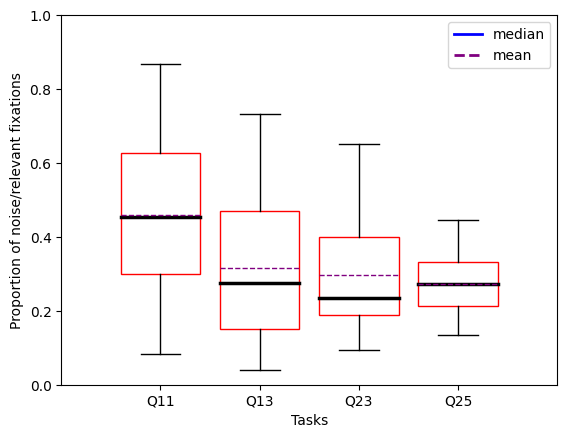

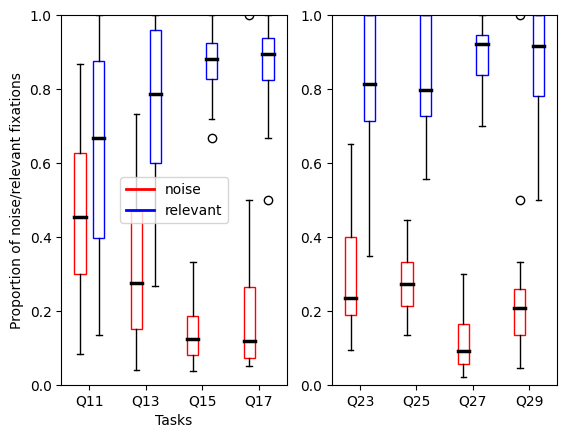

In [ ]:
# Visualizations (for mental processing or cognitive integration)  !!! TO REMOVE !!!

visualizationType = 'mental_proc' # 'mental_proc' or 'cognitive_int'

# for mental processing only
fixationType = 'proc' # 'all', 'proc' or 'deep'

###############################################################################
# Show the proportion in mean for all participant and every task.
_colors = ['red','blue', None, 'red', 'blue', None, 'red', 'blue', None, 'red', 'blue', None]

if visualizationType == 'mental_proc':
    col = 'FixID'
    _m = means[fixationType]
    _gm = gmeans[fixationType]
else:
    col = 'AOIRunCount'
    _m = means['aoirc']
    _gm = gmeans['aoirc']




_n = len(qIDs)
_s = []
_p = list(range(1,_n*3+1))
_x_labels = []
for _qID in qIDs:
    _s.append(_gm.loc[(_gm.currentQuestion==_qID) & (_gm.noise==True),col])
    _s.append(_gm.loc[(_gm.currentQuestion==_qID) & (_gm.noise==False),col])
    _s.append([])
    _x_labels.append(f'Q{_qID}')

boxprops_noise = dict(
    color='red')                 
boxprops = dict(
    color='blue')
medianprops = dict(linewidth=2.5, color='black')
meanlineprops = dict(linestyle='--', linewidth=1, color='purple')
def fill_bplot_color(bplot, colors_fill=None, colors_edge='black'):
    # fill with colors
    
    if not(isinstance(colors_fill, list)): colors_fill = [(colors_fill if colors_fill else 'white') for _ in bplot['boxes']]
    if not(isinstance(colors_edge, list)): colors_edge = [colors_edge for _ in bplot['boxes']]

    for patch, c_fill, c_edge in zip(bplot['boxes'], colors_fill, colors_edge):
        if c_edge:
            patch.set_facecolor(c_fill)
            patch.set_edgecolor(c_edge)




_fig, _ax = plt.subplots()
simple_s = [_s[_i] for _i in [0,3,12,15]]
simple_p = [1,2,3,4]#[_p[_i] for _i in [0,2,12,14]]
_bplot = _ax.boxplot(simple_s,
                        positions=simple_p, widths=.8,
                        meanline=True, showmeans=True,
                        boxprops=boxprops_noise,
                        medianprops=medianprops,
                        meanprops=meanlineprops,
                        patch_artist=True)  # allow to fill with color separately
# fill with colors
fill_bplot_color(_bplot, colors_edge=['red','red','red','red'])

# set axes limits and labels
_ax.set_xlim(0,5)
_ax.set_ylim(0,1)
_ax.set_xticklabels([_x_labels[_i] for _i in [0,1,4,5]])
_ax.set_xlabel('Tasks')
_ax.set_ylabel('Proportion of noise/relevant fixations')

fig.suptitle('Proportion in mean for all participant and every task', fontsize='xx-large')

custom_lines = [matplotlib.lines.Line2D([0], [0], color='b', lw=2),
                matplotlib.lines.Line2D([0], [0], linestyle='--', color='purple', lw=2)]
_ax.legend(custom_lines, ['median', 'mean'])

plt.show()






_fig, _ax = plt.subplots(nrows=1, ncols=2)

_bplot = _ax[0].boxplot(_s[0:12],
                        positions=_p[0:12], widths=0.6,
                        medianprops=medianprops,
                        patch_artist=True)  # allow to fill with color separately
# fill with colors
fill_bplot_color(_bplot, colors_edge=_colors)



_bplot = _ax[1].boxplot(_s[12:24],
                        positions=_p[12:24], widths=0.6,
                        medianprops=medianprops,
                        patch_artist=True)  # allow to fill with color separately
 # fill with colors
fill_bplot_color(_bplot, colors_edge=_colors)


# set axes limits and labels
_ax[0].set_xlim(0,12)
_ax[1].set_xlim(12,24)
_ax[0].set_ylim(0,1)
_ax[1].set_ylim(0,1)
_ax[0].set_xticks([1.5, 4.5, 7.5, 10.5])
_ax[0].set_xticklabels(_x_labels[0:4])
# _ax[1].set_xticks(list(map(lambda x:x+1.5, range(6, 4*3, 3))))
_ax[1].set_xticks([13.5, 16.5, 19.5, 22.5])
_ax[1].set_xticklabels(_x_labels[4:8])
_ax[0].set_xlabel('Tasks')
_ax[0].set_ylabel('Proportion of noise/relevant fixations')

custom_lines = [matplotlib.lines.Line2D([0], [0], color='r', lw=2),
                matplotlib.lines.Line2D([0], [0], color='b', lw=2)]
_ax[0].legend(custom_lines, ['noise', 'relevant'])

fig.suptitle('Proportion in mean for all participant and every task', fontsize='xx-large')

plt.show()


### Fine-grained in space and time

'Mental processing fixations '

AOI_2,1,2
Type3,,
accidentalComlexity,0.185467,0.155522
essentialComlexity,0.263060,0.110652


essentialComlexity


accidentalComlexity


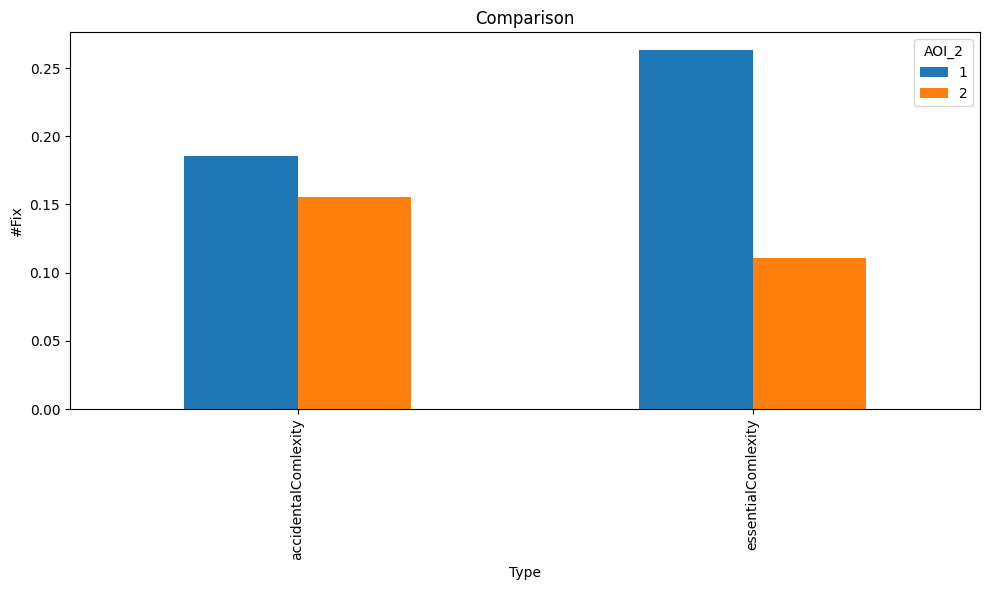

In [ ]:
## Location of noise in time (mental processing)  !!! TO REMOVE !!!
# From the preparation of fixation data
# wholeTaskData = fixData by AOI_1
# allFix = fixData by AOI_1 and AOI_2
# procFix = fixData250 by AOI_1 and AOI_2
# deepProcFix = fixData500 by AOI_1 and AOI_2

###############################################################################
# ## When does the noise occur?
# -> expected to occur in the discovery phase

# => compare the proportion of noise in D-phase vs pD-phase
display('Mental processing fixations ')
_df = procFix

col = 'FixID'

means, gmeans = compute_grouped_mean(df=_df, 
    group_cols=['Type3','AOI_1', 'AOI_2', 'noise'], group_cols_not_for_overall_mean=['participant', 'currentQuestion'], 
    measure_col=col, measure_type='prop', measure_type_attr={'group_total_cols':['Type3']+['participant', 'currentQuestion']},
    additional_filters={'AOI_1': aoi_1_values})
# display(gmeans)
# display(means)

# # Proportion of noise in D-phase
# _noise_Dphase = gmeans.loc[(gmeans.AOI_2==1) & (gmeans.noise),:]

pivot_df = means.loc[means.noise,:].pivot_table(index=['Type3'], columns='AOI_2', values=col)
pivot_df = pivot_df.loc[:, aoi_2_values]
display(pivot_df)

comparison_Noise = {}
measure = '#Fix'
conditions = [(1,2)]
for type3 in type3_values:
    print(type3)
    _group_col = ['participant', 'ComparisionGroup','currentQuestion','Type3','Type4','AOI_2']
    _stat, _p, _n = inferenceTest(_df, _group_col, 
        col, 'count',  'AOI_2', conditions, _group_col[:2], _group_col[:3],
        additional_filters={
            'Type3': type3,
            'AOI_2': aoi_2_values,
            'noise': True
            },
        do_print=False)
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))

comparison_Noise['allFix'] = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}
plotComparison(pivot_df, measure)


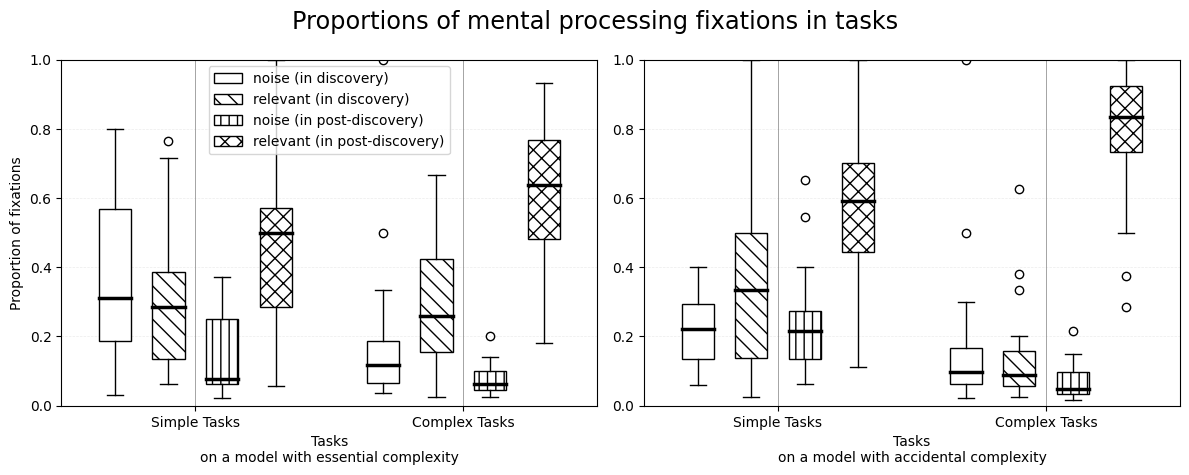

In [42]:
# Visualization for mental processing
###############################################################################
# Show the proportion in mean for all participant and every task.

col = 'FixID'

_dqIDs = {'essential': [[11, 13], [15, 17]], 'accidental':[[23, 25], [27, 29]]}
_colors =['black'] #['orange', 'lightblue', 'red','blue', None]
_hatches = ['', '\\\\', '||', 'xx', None]


_fig, _ax = plt.subplots(nrows=1, ncols=2)
_fig.set_figwidth(12)

_s = []
_x_labels = []
#_colors = []
# for _qID in qIDs:
#     _s.append(gmeans.loc[(gmeans.currentQuestion==_qID) & (gmeans.AOI_2==1) & (gmeans.noise==True),col])
#     _s.append(gmeans.loc[(gmeans.currentQuestion==_qID) & (gmeans.AOI_2==1) & (gmeans.noise==False),col])
#     _s.append(gmeans.loc[(gmeans.currentQuestion==_qID) & (gmeans.AOI_2==2) & (gmeans.noise==True),col])
#     _s.append(gmeans.loc[(gmeans.currentQuestion==_qID) & (gmeans.AOI_2==2) & (gmeans.noise==False),col])
#     _s.append([])
#     _x_labels.append(f'Q{_qID}')

for _t in ['essential', 'accidental']:
    for _qIDs in _dqIDs[_t]:
        _s.append(gmeans.loc[(gmeans.currentQuestion.isin(_qIDs)) & (gmeans.AOI_2==1) & (gmeans.noise==True),col])
        _s.append(gmeans.loc[(gmeans.currentQuestion.isin(_qIDs)) & (gmeans.AOI_2==1) & (gmeans.noise==False),col])
        _s.append(gmeans.loc[(gmeans.currentQuestion.isin(_qIDs)) & (gmeans.AOI_2==2) & (gmeans.noise==True),col])
        _s.append(gmeans.loc[(gmeans.currentQuestion.isin(_qIDs)) & (gmeans.AOI_2==2) & (gmeans.noise==False),col])
        _s.append([])

        #_colors += ['orange', 'lightblue', 'red','blue', None]

_x_labels = ['Simple Tasks', 'Complex Tasks', 'Simple Tasks', 'Complex Tasks']


_n = 4
_x_spaces = 5
_max_x = int(len(_s)/2)
_p = list(range(1,_n*_x_spaces+1))

boxprops_noise = dict(
    color='red')                 
boxprops = dict(
    color='blue')
medianprops = dict(linewidth=2.5, color='black')

_bplot = _ax[0].boxplot(_s[0:_max_x],
                        positions=_p[0:_max_x], widths=0.6,
                        medianprops=medianprops,
                        patch_artist=True)  # allow to fill with color separately
# fill with colors
_pos = 0
for patch in _bplot['boxes']:
    _c = _colors[_pos%len(_colors)]
    _h = _hatches[_pos%len(_hatches)]
    if _c:
        patch.set_facecolor('white')
        patch.set_edgecolor(_c)
    if _h:
        patch.set_hatch(_h)
    _pos += 1
        


_bplot = _ax[1].boxplot(_s[_max_x:2*_max_x],
                        positions=_p[_max_x:2*_max_x], widths=0.6,
                        medianprops=medianprops,
                        patch_artist=True)  # allow to fill with color separately
 # fill with colors
_pos = 0
for patch in _bplot['boxes']:
    _c = _colors[_pos%len(_colors)]
    _h = _hatches[_pos%len(_hatches)]
    if _c:
        patch.set_facecolor('white')
        patch.set_edgecolor(_c)
    if _h:
        patch.set_hatch(_h)
    _pos += 1

# set axes limits and labels
_ax[0].set_xlim(0,_max_x)
_ax[1].set_xlim(_max_x,2*_max_x)
_ax[0].set_ylim(0,1)
_ax[1].set_ylim(0,1)
_ax[0].set_xticks(list(frange(_x_spaces/2,_max_x,_x_spaces))) #[1.5, 4.5, 7.5, 10.5])
_ax[0].set_xticklabels(_x_labels[0:int(_n/2)])
# _ax[1].set_xticks(list(map(lambda x:x+1.5, range(6, 4*3, 3))))
_ax[1].set_xticks(list(frange(_max_x+_x_spaces/2,_max_x*2,_x_spaces))) #([13.5, 16.5, 19.5, 22.5])
_ax[1].set_xticklabels(_x_labels[int(_n/2):_n])
_ax[0].set_xlabel('Tasks\non a model with essential complexity')
_ax[1].set_xlabel('Tasks\non a model with accidental complexity')
_ax[0].set_ylabel('Proportion of fixations')
_ax[0].grid(visible=True, which='major', axis='y', color='gray', linestyle='--', linewidth=.5, alpha=.15)
_ax[0].grid(visible=True, which='major', axis='x', color='black', linestyle='-', linewidth=.5, alpha=.50)
_ax[1].grid(visible=True, which='major', axis='y', color='gray', linestyle='--', linewidth=.5, alpha=.15)
_ax[1].grid(visible=True, which='major', axis='x', color='black', linestyle='-', linewidth=.5, alpha=.50)

custom_lines = [matplotlib.patches.Patch(facecolor='w', edgecolor='k', hatch=_hatches[0]),#matplotlib.lines.Line2D([0], [0], color='orange', lw=2),
                matplotlib.patches.Patch(facecolor='w', edgecolor='k', hatch=_hatches[1]),
                matplotlib.patches.Patch(facecolor='w', edgecolor='k', hatch=_hatches[2]),
                matplotlib.patches.Patch(facecolor='w', edgecolor='k', hatch=_hatches[3])]
_ax[0].legend(custom_lines, ['noise (in discovery)', 'relevant (in discovery)', 'noise (in post-discovery)', 'relevant (in post-discovery)'])

_fig.suptitle('Proportions of mental processing fixations in tasks', fontsize='xx-large')
_fig.tight_layout()


_dir = IMG_DIR + r"\Fine-grained analysis 2"
if not os.path.isdir(_dir):
    os.mkdir(_dir)
plt.savefig(_dir + r"\Fine-grained_analysis_dist_fixation.pdf")
plt.savefig(_dir + r"\Fine-grained_analysis_dist_fixation.png")


plt.show()


'Fixations > 250ms'

AOI_2                                       1         2
Type3               Type5                              
accidentalComlexity ComposedComplex  0.140232  0.434599
                    ComposedSimple   0.282099  0.400454
essentialComlexity  ComposedComplex  0.228517  0.344538
                    ComposedSimple   0.328115  0.293969

essentialComlexity, ComposedSimple
essentialComlexity, ComposedComplex


accidentalComlexity, ComposedSimple
accidentalComlexity, ComposedComplex


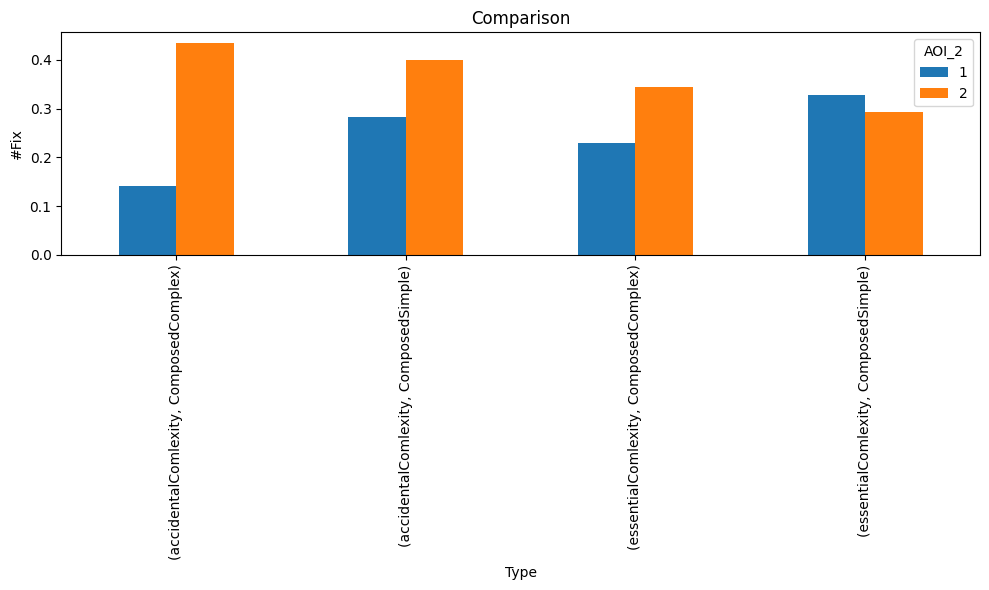

'Fixations > 500ms'

AOI_2                                       1         2
Type3               Type5                              
accidentalComlexity ComposedComplex  0.249093  0.523308
                    ComposedSimple   0.391245  0.623016
essentialComlexity  ComposedComplex  0.264461  0.615775
                    ComposedSimple   0.541090  0.533796

essentialComlexity, ComposedSimple
essentialComlexity, ComposedComplex


accidentalComlexity, ComposedSimple
accidentalComlexity, ComposedComplex


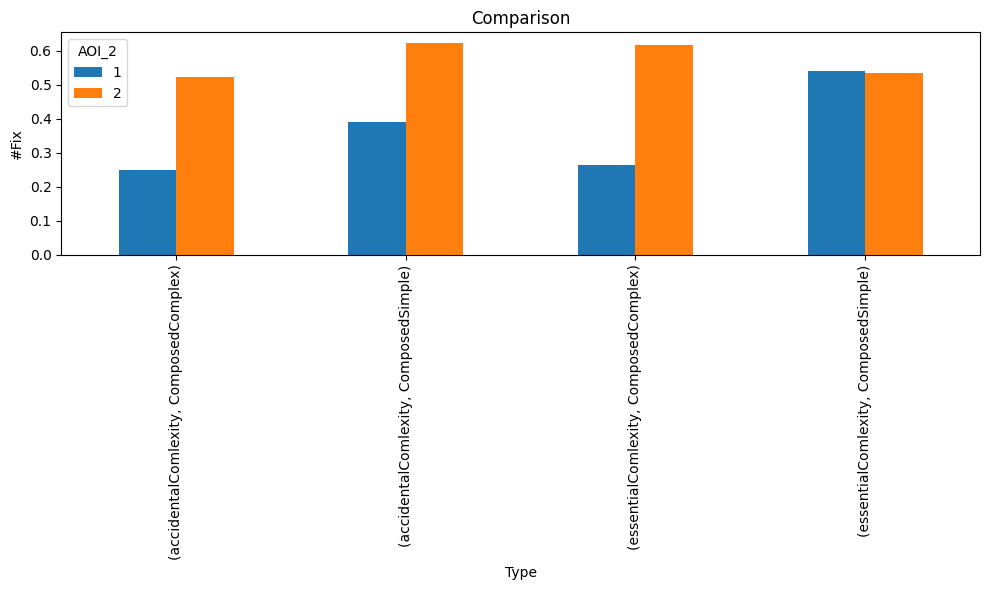

In [ ]:
# Where is the highest proportion of mental/deep mental processing?  !!! TO REMOVE !!!
# -> expectation: more mental processing should occur in the pD-phase.

type3_values = ['essentialComlexity','accidentalComlexity']
type4_values = ['Simple','Complex']
type5_values = ['ComposedSimple','ComposedComplex']
AOI_values = [1,2]
conditions = [(1,2)]




display('Fixations > 250ms')
_df = procFix
means, gmeans = compute_grouped_mean(df=_df, 
    group_cols=['Type3','Type5','AOI_1', 'AOI_2', 'noise'], group_cols_not_for_overall_mean=['participant', 'currentQuestion'], 
    measure_col=col, measure_type='prop', measure_type_attr={'group_total_cols':['Type3', 'Type5']+['participant', 'currentQuestion']},
    additional_filters={'AOI_1': aoi_1_values})


# Proportion of non-noise in D & pD phases
pivot_df = means.pivot_table(index=['Type3', 'Type5'], columns='AOI_2', values=col)
pivot_df = pivot_df.loc[:, aoi_2_values]
display(pivot_df)

comparison_NonNoise = {}
measure = '#Fix'
for type3 in type3_values:
    for type5 in type5_values:
        print(f"{type3}, {type5}")
        _gorup_col = ['participant', 'ComparisionGroup','currentQuestion','Type3','Type5','AOI_2']
        _stat, _p, _n = inferenceTest(_df, _gorup_col, 
            col, 'count',  'AOI_2', conditions, _gorup_col[:2], _gorup_col[:3],
            additional_filters={
                'Type3': type3,
                'Type5': type5,
                'AOI_1': aoi_1_values
                },
            do_print=False)
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))

comparison_Noise['procFix'] = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}
plotComparison(pivot_df, measure)




display('Fixations > 500ms')
_df = deepProcFix
means, gmeans = compute_grouped_mean(df=_df, 
    group_cols=['Type3','AOI_1','Type5', 'AOI_2', 'noise'], group_cols_not_for_overall_mean=['participant', 'currentQuestion'], 
    measure_col=col, measure_type='prop', measure_type_attr={'group_total_cols':['Type3','Type5']+['participant', 'currentQuestion']},
    additional_filters={'AOI_1': aoi_1_values})


# Proportion of non-noise in D & pD phases
pivot_df = means.pivot_table(index=['Type3','Type5'], columns='AOI_2', values=col)
pivot_df = pivot_df.loc[:, aoi_2_values]
display(pivot_df)

comparison_NonNoise = {}
measure = '#Fix'
for type3 in type3_values:
    for type5 in type5_values:
        print(f"{type3}, {type5}")
        _gorup_col = ['participant', 'ComparisionGroup','currentQuestion','Type3','Type5','AOI_2']
        _stat, _p, _n = inferenceTest(_df, _gorup_col, 
            col, 'count',  'AOI_2', conditions, _gorup_col[:2], _gorup_col[:3],
            additional_filters={
                'Type3': type3,
                'Type5': type5,
                'AOI_1': aoi_1_values
                },
            do_print=False)
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))

comparison_Noise['deepFix'] = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}
plotComparison(pivot_df, measure)


'All fixations '

AOI_2,1.0,2.0
Type3,,
accidentalComlexity,0.153979,0.114991
essentialComlexity,0.203168,0.069244


essentialComlexity


accidentalComlexity


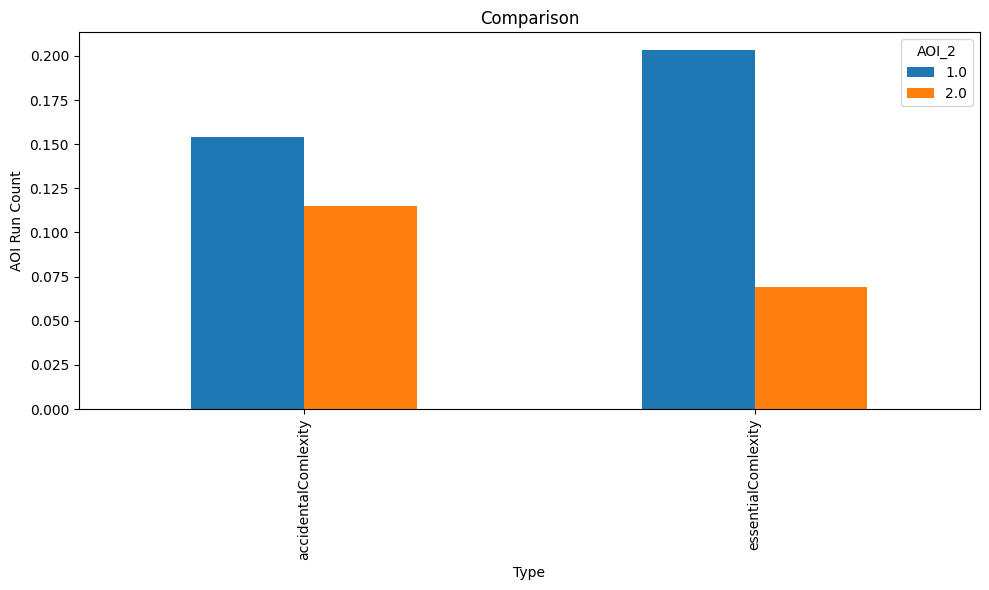

In [ ]:
## Location of noise in time (cognitive integration)  !!! TO REMOVE !!!
# From the preparation of f_aoircData

###############################################################################
# ## When does the noise occur?
# -> expected to occur in the discovery phase

# => compare the proportion of noise in D-phase vs pD-phase
display('All fixations ')
_df = f_aoircData

col = 'AOIRunCount'

means, gmeans = compute_grouped_mean(df=_df, 
    group_cols=['Type3','AOI_1', 'AOI_2', 'noise'], group_cols_not_for_overall_mean=['participant', 'currentQuestion'], 
    measure_col=col, measure_type='prop', measure_type_attr={'group_total_cols':['Type3']+['participant', 'currentQuestion']},
    additional_filters={'AOI_1': aoi_1_values})
# display(gmeans)
# display(means)

# # Proportion of noise in D-phase
# _noise_Dphase = gmeans.loc[(gmeans.AOI_2==1) & (gmeans.noise),:]

pivot_df = means.loc[means.noise,:].pivot_table(index=['Type3'], columns='AOI_2', values=col)
pivot_df = pivot_df.loc[:, aoi_2_values]
display(pivot_df)

comparison_Noise = {}
measure = 'AOI Run Count'
conditions = [(1,2)]
for type3 in type3_values:
    print(type3)
    _group_col = ['participant', 'ComparisionGroup','currentQuestion','Type3','Type4','AOI_2']
    _stat, _p, _n = inferenceTest(_df, _group_col, 
        col, 'count',  'AOI_2', conditions, _group_col[:2], _group_col[:3],
        additional_filters={
            'Type3': type3,
            'AOI_2': aoi_2_values,
            'noise': True
            },
        do_print=False)
    
    for _i in range(len(conditions)):
        display(HTML(f"<span style='color: {'green' if _p[_i] < 0.05 else 'red'};'>" +
                     f"{conditions[_i][0]} vs {conditions[_i][1]}, N = {_n[_i]}: p-value = {_p[_i]}</span>"))

comparison_Noise['allFix'] = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}
plotComparison(pivot_df, measure)


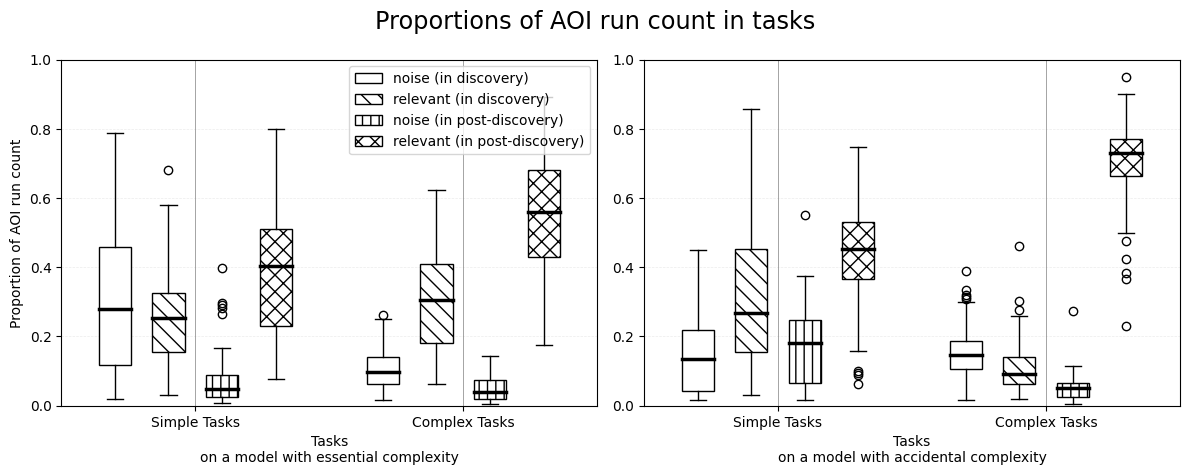

In [45]:
# Visualization for cognitive integration
###############################################################################
# Show the proportion in mean for all participant and every task.

col = 'AOIRunCount'

_dqIDs = {'essential': [[11, 13], [15, 17]], 'accidental':[[23, 25], [27, 29]]}
_colors =['black'] #['orange', 'lightblue', 'red','blue', None]
_hatches = ['', '\\\\', '||', 'xx', None]


_fig, _ax = plt.subplots(nrows=1, ncols=2)
_fig.set_figwidth(12)

_s = []
_x_labels = []
#_colors = []
# for _qID in qIDs:
#     _s.append(gmeans.loc[(gmeans.currentQuestion==_qID) & (gmeans.AOI_2==1) & (gmeans.noise==True),col])
#     _s.append(gmeans.loc[(gmeans.currentQuestion==_qID) & (gmeans.AOI_2==1) & (gmeans.noise==False),col])
#     _s.append(gmeans.loc[(gmeans.currentQuestion==_qID) & (gmeans.AOI_2==2) & (gmeans.noise==True),col])
#     _s.append(gmeans.loc[(gmeans.currentQuestion==_qID) & (gmeans.AOI_2==2) & (gmeans.noise==False),col])
#     _s.append([])
#     _x_labels.append(f'Q{_qID}')

for _t in ['essential', 'accidental']:
    for _qIDs in _dqIDs[_t]:
        _s.append(gmeans.loc[(gmeans.currentQuestion.isin(_qIDs)) & (gmeans.AOI_2==1) & (gmeans.noise==True),col])
        _s.append(gmeans.loc[(gmeans.currentQuestion.isin(_qIDs)) & (gmeans.AOI_2==1) & (gmeans.noise==False),col])
        _s.append(gmeans.loc[(gmeans.currentQuestion.isin(_qIDs)) & (gmeans.AOI_2==2) & (gmeans.noise==True),col])
        _s.append(gmeans.loc[(gmeans.currentQuestion.isin(_qIDs)) & (gmeans.AOI_2==2) & (gmeans.noise==False),col])
        _s.append([])

        #_colors += ['orange', 'lightblue', 'red','blue', None]

_x_labels = ['Simple Tasks', 'Complex Tasks', 'Simple Tasks', 'Complex Tasks']


_n = 4
_x_spaces = 5
_max_x = int(len(_s)/2)
_p = list(range(1,_n*_x_spaces+1))

boxprops_noise = dict(
    color='red')                 
boxprops = dict(
    color='blue')
medianprops = dict(linewidth=2.5, color='black')

_bplot = _ax[0].boxplot(_s[0:_max_x],
                        positions=_p[0:_max_x], widths=0.6,
                        medianprops=medianprops,
                        patch_artist=True)  # allow to fill with color separately
# fill with colors
_pos = 0
for patch in _bplot['boxes']:
    _c = _colors[_pos%len(_colors)]
    _h = _hatches[_pos%len(_hatches)]
    if _c:
        patch.set_facecolor('white')
        patch.set_edgecolor(_c)
    if _h:
        patch.set_hatch(_h)
    _pos += 1
        


_bplot = _ax[1].boxplot(_s[_max_x:2*_max_x],
                        positions=_p[_max_x:2*_max_x], widths=0.6,
                        medianprops=medianprops,
                        patch_artist=True)  # allow to fill with color separately
 # fill with colors
_pos = 0
for patch in _bplot['boxes']:
    _c = _colors[_pos%len(_colors)]
    _h = _hatches[_pos%len(_hatches)]
    if _c:
        patch.set_facecolor('white')
        patch.set_edgecolor(_c)
    if _h:
        patch.set_hatch(_h)
    _pos += 1

# set axes limits and labels
_ax[0].set_xlim(0,_max_x)
_ax[1].set_xlim(_max_x,2*_max_x)
_ax[0].set_ylim(0,1)
_ax[1].set_ylim(0,1)
_ax[0].set_xticks(list(frange(_x_spaces/2,_max_x,_x_spaces))) #[1.5, 4.5, 7.5, 10.5])
_ax[0].set_xticklabels(_x_labels[0:int(_n/2)])
# _ax[1].set_xticks(list(map(lambda x:x+1.5, range(6, 4*3, 3))))
_ax[1].set_xticks(list(frange(_max_x+_x_spaces/2,_max_x*2,_x_spaces))) #([13.5, 16.5, 19.5, 22.5])
_ax[1].set_xticklabels(_x_labels[int(_n/2):_n])
_ax[0].set_xlabel('Tasks\non a model with essential complexity')
_ax[1].set_xlabel('Tasks\non a model with accidental complexity')
_ax[0].set_ylabel('Proportion of AOI run count')
_ax[0].grid(visible=True, which='major', axis='y', color='gray', linestyle='--', linewidth=.5, alpha=.15)
_ax[0].grid(visible=True, which='major', axis='x', color='black', linestyle='-', linewidth=.5, alpha=.50)
_ax[1].grid(visible=True, which='major', axis='y', color='gray', linestyle='--', linewidth=.5, alpha=.15)
_ax[1].grid(visible=True, which='major', axis='x', color='black', linestyle='-', linewidth=.5, alpha=.50)

custom_lines = [matplotlib.patches.Patch(facecolor='w', edgecolor='k', hatch=_hatches[0]),#matplotlib.lines.Line2D([0], [0], color='orange', lw=2),
                matplotlib.patches.Patch(facecolor='w', edgecolor='k', hatch=_hatches[1]),
                matplotlib.patches.Patch(facecolor='w', edgecolor='k', hatch=_hatches[2]),
                matplotlib.patches.Patch(facecolor='w', edgecolor='k', hatch=_hatches[3])]
_ax[0].legend(custom_lines, ['noise (in discovery)', 'relevant (in discovery)', 'noise (in post-discovery)', 'relevant (in post-discovery)'])

_fig.suptitle('Proportions of AOI run count in tasks', fontsize='xx-large')
_fig.tight_layout()


_dir = IMG_DIR + r"\Fine-grained analysis 2"
if not os.path.isdir(_dir):
    os.mkdir(_dir)
plt.savefig(_dir + r"\Fine-grained_analysis_dist_aoirc.pdf")
plt.savefig(_dir + r"\Fine-grained_analysis_dist_aoirc.png")


plt.show()


In [ ]:
### Revisit ratio for all tasks  !!! TO REMOVE !!!
# allFix = fixData by AOI_1 and AOI_2 with indication of noise

selectedPIDs = participantIDs
nPIDs = len(selectedPIDs)

selectedQIDs = [7, 9, 3, 5, 19, 21] + qIDs
nQIDs = len(selectedQIDs)
selectedTIDs = [4, 5, 2, 3, 10, 11] + taskIDs
nTIDs = len(selectedTIDs)

type3_values = ['essentialComlexity','accidentalComlexity']
type4_values = ['Simple','complex']
AOI_1_values = [1,2]
AOI_2_values = [1,2]

simple_task_qIDs = [3, 5]
simple_task_IDs = [2, 3]

def set_dt(df, tsCol = 'Timestamp', dtCol = 'dt'):
    dt = df[tsCol] - df[tsCol].iloc[0]
    df[dtCol] = dt

def set_element_nona(df, naLabel = 'unk', elmtColName = 'element', nonaSuffix = '_nona'):
    # Add the 'element' column in df
    nonaColName = elmtColName + nonaSuffix
    df[nonaColName] = df[elmtColName]
    # Replace NA entries by a given label
    df.loc[df[nonaColName].isna(), [nonaColName]] = naLabel

    # Create a dictionary of elements, where elements with naLabel are in first position
    # with the associated value -1
    model_elements = df[nonaColName].unique()
    model_elements = np.insert(np.delete(model_elements, model_elements=='unk'), 0, naLabel)
    model_elements = {model_elements[i]:i for i in range(len(model_elements))}
    model_elements[naLabel] = -1

    return model_elements

def filter_elements(df, model_elements, params={}):
    # Remove elements not in EMI_SELECTED_OBJ_ID_PATTERNS
    obj_patterns = EMI_SELECTED_OBJ_ID_PATTERNS
    if 'obj_patterns' in params: obj_patterns = params['obj_patterns']
    dElmt = np.array([model_elements[k] for k in df['element_nona']])
    filtered_out = [
        any(list(map(lambda x: e.find(x) > -1, obj_patterns)))
        for e in df['element_nona']
    ]
    #dElmt = dElmt[filtered_out]
    #dsElmt = ds[filtered_out]

    return dElmt, filtered_out

def find_qElmt(df, qData):
    # Find first fix on the elements of the question
    qElements = (qData['element1'].iloc[0], qData['element2'].iloc[0])
    df['qElement'] = 0
    df.loc[df['element']==qElements[0], ['qElement']] = 1
    df.loc[df['element']==qElements[1], ['qElement']] = 2

    # Get the first occurence of fixation on a element (if exists!)
    d_qElements_firstFix = []
    if any(df.qElement == 1): d_qElements_firstFix.append(df[df.qElement == 1].iloc[0])
    else: d_qElements_firstFix.append(None)
    if any(df.qElement == 2): d_qElements_firstFix.append(df[df.qElement == 2].iloc[0])
    else: d_qElements_firstFix.append(None)

    return qElements, d_qElements_firstFix


### For all participants
measures = {'pID': [], 'tID': [], 'phase1': [], 'phase2': []}
for pID in selectedPIDs:

    ### For all tasks
    for i in range(nQIDs): #taskIDs:
        qID = selectedQIDs[i]
        tID = selectedTIDs[i]

        _filter = \
            (allTaskFixData['currentQuestion'] == qID).values & \
            (allTaskFixData['participant'] == pID).values
        
        # /!\ 
        # Data for Simple tasks were duplicated to make comparisons
        # in the deductive analysis. Here, we keep only one version
        # of the data for the simple tasks.
        # /!\
        if qID in simple_task_qIDs:
            _filter &= (allTaskFixData['Type3'] == type3_values[0]).values

        df = allTaskFixData.loc[_filter].copy(deep=True)

        
        if not any(_filter): continue
        set_dt(df)
        model_elements = set_element_nona(df)
        # dElmt, dElmt_filter = filter_elements(df, model_elements, params={
        #     'obj_patterns': EMI_ACTIVITY_OBJ_ID_PATTERNS
        # })

        # qData = questionsFileParsed[questionsFileParsed['id'] == qID]
        
        # qElements, d_qElements_firstFix = find_qElmt(dp, qData)

        # # Seperate in disc./post-disc. phases
        # # In df, the column 'Phase' contains 1 or 2 depending on the phase.
        # dictPhases = get_subparts(df, qElements)
        # dPh1, dPh2 = dictPhases['search']['d'], dictPhases['solve']['d']

        # dPh1, dPh2 as disc and post-disc phases
        dPh1, dPh2 = df.loc[df['AOI_2']==1], df.loc[df['AOI_2']==2]


        temp_dPh = dPh1.copy(deep=True)
        _ldPh1 = len(dPh1.index)
        # Remove consecutive fixation on same element
        if _ldPh1 > 0:
            for i in range(1, _ldPh1):
                idx = dPh1.index[i]
                Xi, Xii = dPh1.iloc[i-1], dPh1.iloc[i]

                if Xii['element_nona'] == Xi['element_nona']: 
                    temp_dPh.drop(idx, inplace=True)
            dPh1 = temp_dPh.copy(deep=True)

        temp_dPh = dPh2.copy(deep=True)
        _ldPh2 = len(dPh2.index)
        if _ldPh2 > 0:
            for i in range(1, _ldPh2):
                idx = dPh2.index[i]
                Xi, Xii = dPh2.iloc[i-1], dPh2.iloc[i]

                if Xii['element_nona'] == Xi['element_nona']:
                    temp_dPh.drop(idx, inplace=True)
            dPh2 = temp_dPh.copy(deep=True)
        
        #    rho_revisit = n(revisits)/n(first_visits + revisits)
        # => rho_revisit = 1 - n(first_visits)/n(first_visits + revisits)
        # n(first_visits) = n(elements accessed once in the phase)
        # n(first_visits + revisits) = n(fixations in the phase)
        n1 = None
        if _ldPh1 > 0:
            n1 = 1- len(dPh1['element_nona'].unique()) / _ldPh1
        n2 = None
        if _ldPh2 > 0:
            n2 = 1- len(dPh2['element_nona'].unique()) / _ldPh2

        measures['pID'].append(pID)
        measures['tID'].append(tID)
        measures['phase1'].append(n1)
        measures['phase2'].append(n2)


measures = pd.DataFrame(measures)

display(measures.iloc[0:12, :])



,pID,tID,phase1,phase2
0,P12,4,0.857143,0.866197
1,P12,5,0.914634,0.868421
2,P12,2,0.829730,0.730924
3,P12,3,0.769953,0.803419
4,P12,10,0.756410,0.836735
5,P12,11,0.800000,0.860465
6,P12,6,0.830769,0.716981
7,P12,7,0.833333,0.764045
8,P12,8,0.801980,0.904696
9,P12,9,0.792169,0.825000
